In [1]:
# Εγκατάσταση των βιβλιοθηκών numpy (για αριθμητικούς υπολογισμούς), pandas (για επεξεργασία δεδομένων),
# matplotlib και seaborn (για οπτικοποίηση δεδομένων), scikit-learn (για machine learning) και torch (για deep learning)
# Οι βιβλιοθήκες είναι ήδη εγκατεστημένες στο περιβάλλον και δεν χρειάζεται να τις ξαναεγκαταστήσουμε.
# Αν κάποιος τρέξει το notebook σε νέο περιβάλλον, θα χρειαστεί να εκτελέσει την εξής εντολή για να εγκαταστήσει τις βιβλιοθήκες:
# !pip install numpy pandas matplotlib seaborn scikit-learn torch


In [112]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών

import torch # για deep learning
import torch.nn as nn # για νευρωνικά δίκτυα
import torch.optim as optim # για βελτιστοποίηση
from torch.utils.data import DataLoader, TensorDataset # για διαχείριση δεδομένων
import matplotlib.pyplot as plt # για οπτικοποίηση δεδομένων
import seaborn as sns # για οπτικοποίηση δεδομένων
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # για αξιολόγηση μοντέλου
from sklearn.preprocessing import label_binarize



In [107]:
# Ορισμός του seed για αναπαραγωγιμότητα
seed = 42
random.seed(seed)  # Για τη βιβλιοθήκη random
np.random.seed(seed)  # Για τη βιβλιοθήκη NumPy

# Για PyTorch, αν το χρησιμοποιείς:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Σε πολλαπλές GPU αν υπάρχουν

# Ρυθμίσεις για αναπαραγωγιμότητα με GPU
torch.backends.cudnn.deterministic = True  # Αναγκάζει ντετερμινιστικές πράξεις
torch.backends.cudnn.benchmark = False  # Απενεργοποιεί το benchmarking για τα βελτιστοποιημένα μεγέθη μπλοκ

# Ελέγχουμε εάν το seed έχει ρυθμιστεί σωστά
print(f"Random seed set to {seed}")

Random seed set to 42


In [108]:
# Ελέγχουμε αν υπάρχει GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρησιμοποιούμε τη συσκευή: {device}")


Χρησιμοποιούμε τη συσκευή: cuda


In [109]:
# Φορτώνουμε τα δεδομένα από το αρχείο που αποθηκεύσαμε

data = np.load('train_test_images_normalized_images.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']  # Φόρτωση των ονομάτων των κατηγοριών

# Εκτύπωση των σχημάτων και των ονομάτων των κατηγοριών
print(f"Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: {X_train.shape}, ετικέτες: {y_train.shape}")
print(f"Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: {X_test.shape}, ετικέτες: {y_test.shape}")
print(f"Ονόματα Κατηγοριών: {class_names}")

Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: (2800, 4096), ετικέτες: (2800,)
Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: (1200, 4096), ετικέτες: (1200,)
Ονόματα Κατηγοριών: ['BreastMRI' 'ChestCT' 'CXR' 'Hand']


Ο στόχος είναι να χρησιμοποιήσουμε τα data με τέτοιον τρόπο, προκειμένου το CNN δίκτυο που θα δημιουργήσουμε να μπορεί να αναγνωρίσει μοτίβα μέσα στις εικόνες. Το CNN είναι βελτιστοποιημένο για να επεξεργάζεται εικόνες και να ανιχνεύει τοπικά μοτίβα (π.χ., άκρα, υφές, σχήματα κ.λπ.) σε εικόνες. Επομένως, επιλέγουμε να αξιοποιήσουμε τα δεδομένα όπως ήταν πριν την εφαρμογή PCA, διότι με την εφαρμογή του ενδεχομένως χάσουμε αυτά τα τοπικά μοτίβα, καθώς το PCA, συνήθως, εξάγει γραμμικά συνδυασμένα χαρακτηριστικά και ίσως χάσουμε πληροφορία που το CNN θα μπορούσε να εκμεταλλευτεί.

Αρχικά δημιουργούμε ένα δίκτυο με 3 επίπεδα συνελίξεων (conv1, conv2, conv3), το καθένα με ReLU ως συνάρτηση ενεργοποίησης. Χρησιμοποιούμε MaxPooling2d για να μειώσουμε τις διαστάσεις των χαρακτηριστικών και να αποφύγουμε την υπερβολική υπολογιστική επιβάρυνση. Κάθε επίπεδο MaxPool2d μειώνει τις διαστάσεις των εικόνων κατά το ήμισυ. Τα επίπεδα fc1 και fc2 είναι πλήρως συνδεδεμένα, και χρησιμοποιούνται για την κατηγοριοποίηση των εξαγόμενων χαρακτηριστικών σε κατηγορίες. Το μοντέλο καταλήγει με ένα επίπεδο εξόδου (output layer) που έχει num_classes μονάδες (μία για κάθε κατηγορία), και η έξοδος είναι μια πιθανότητα για κάθε κατηγορία.

In [110]:
# Δημιουργία του μοντέλου CNN
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate, activation_fn):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.activation_fn = getattr(nn, activation_fn)()
        self.dropout = nn.Dropout(dropout_rate)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation_fn(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Προετοιμασία δεδομένων και DataLoader
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 64, 64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 64, 64)

train_data = TensorDataset(X_train_tensor, torch.tensor(y_train_encoded, dtype=torch.long))
test_data = TensorDataset(X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Δημιουργία του CNN μοντέλου
model = CNN(num_classes=len(label_encoder.classes_), dropout_rate=0.5, activation_fn='ReLU')

# Ορισμός του Loss Function και του Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Εκπαίδευση του μοντέλου
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=20):
    train_losses = []
    train_accuracies = []
    test_losses = []  # Λίστα για τα Test Losses
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Εκπαίδευση του μοντέλου για κάθε μπατς
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Εκτύπωση των αποτελεσμάτων για την εκπαίδευση κάθε εποχής
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Αξιολόγηση του μοντέλου στο Test Set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        test_losses.append(test_loss / len(test_loader))  # Αποθήκευση Test Loss
        test_accuracies.append(test_accuracy)

    # Εκτύπωση των τελικών αποτελεσμάτων
    print(f"\nTest Accuracy: {test_accuracies[-1]:.2f}%")

    # Επιστροφή των αποτελεσμάτων μετά την εκπαίδευση
    return train_losses, train_accuracies, test_losses, test_accuracies

# Εκτέλεση της εκπαίδευσης
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=20)


Epoch 1/20, Loss: 0.1228, Accuracy: 96.46%
Epoch 2/20, Loss: 0.0194, Accuracy: 99.57%
Epoch 3/20, Loss: 0.0063, Accuracy: 99.79%
Epoch 4/20, Loss: 0.0098, Accuracy: 99.57%
Epoch 5/20, Loss: 0.0048, Accuracy: 99.89%
Epoch 6/20, Loss: 0.0200, Accuracy: 99.61%
Epoch 7/20, Loss: 0.0487, Accuracy: 99.07%
Epoch 8/20, Loss: 0.0234, Accuracy: 99.57%
Epoch 9/20, Loss: 0.0005, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0003, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0006, Accuracy: 99.93%
Epoch 13/20, Loss: 0.0005, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0002, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%

Test Accuracy: 99.50%


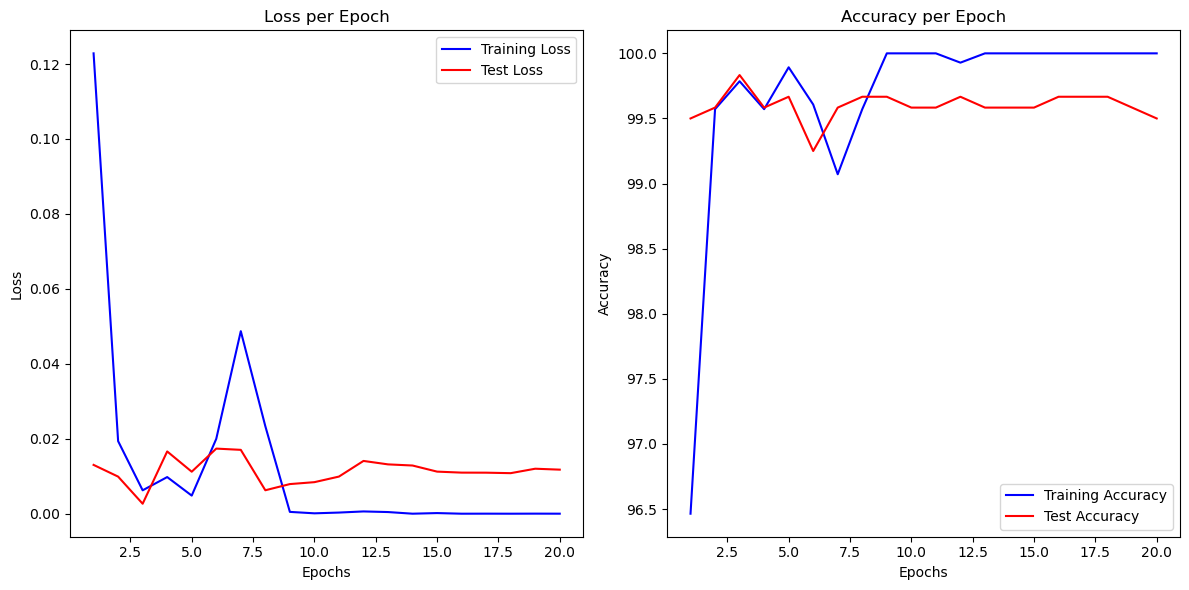

In [111]:
# Οπτικοποίηση των καμπυλών μάθησης
epochs = range(1, num_epochs + 1)

# Καμπύλη απώλειας
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Καμπύλη ακρίβειας
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Εμφάνιση του διαγράμματος
plt.tight_layout()
plt.show()


Training with lr=0.001, activation_fn=ReLU, dropout_rate=0.2
Epoch 1/20, Loss: 0.1138, Accuracy: 96.82%
Epoch 2/20, Loss: 0.0428, Accuracy: 98.89%
Epoch 3/20, Loss: 0.0255, Accuracy: 99.29%
Epoch 4/20, Loss: 0.0330, Accuracy: 99.00%
Epoch 5/20, Loss: 0.0254, Accuracy: 99.25%
Epoch 6/20, Loss: 0.0213, Accuracy: 99.39%
Epoch 7/20, Loss: 0.0249, Accuracy: 99.29%
Epoch 8/20, Loss: 0.0146, Accuracy: 99.54%
Epoch 9/20, Loss: 0.0139, Accuracy: 99.71%
Epoch 10/20, Loss: 0.0134, Accuracy: 99.71%
Epoch 11/20, Loss: 0.0196, Accuracy: 99.43%
Epoch 12/20, Loss: 0.0185, Accuracy: 99.57%
Epoch 13/20, Loss: 0.0082, Accuracy: 99.79%
Epoch 14/20, Loss: 0.0175, Accuracy: 99.46%
Epoch 15/20, Loss: 0.0114, Accuracy: 99.61%
Epoch 16/20, Loss: 0.0132, Accuracy: 99.71%
Epoch 17/20, Loss: 0.0234, Accuracy: 99.29%
Epoch 18/20, Loss: 0.0137, Accuracy: 99.71%
Epoch 19/20, Loss: 0.0116, Accuracy: 99.75%
Epoch 20/20, Loss: 0.0089, Accuracy: 99.71%

Test Accuracy: 99.67%


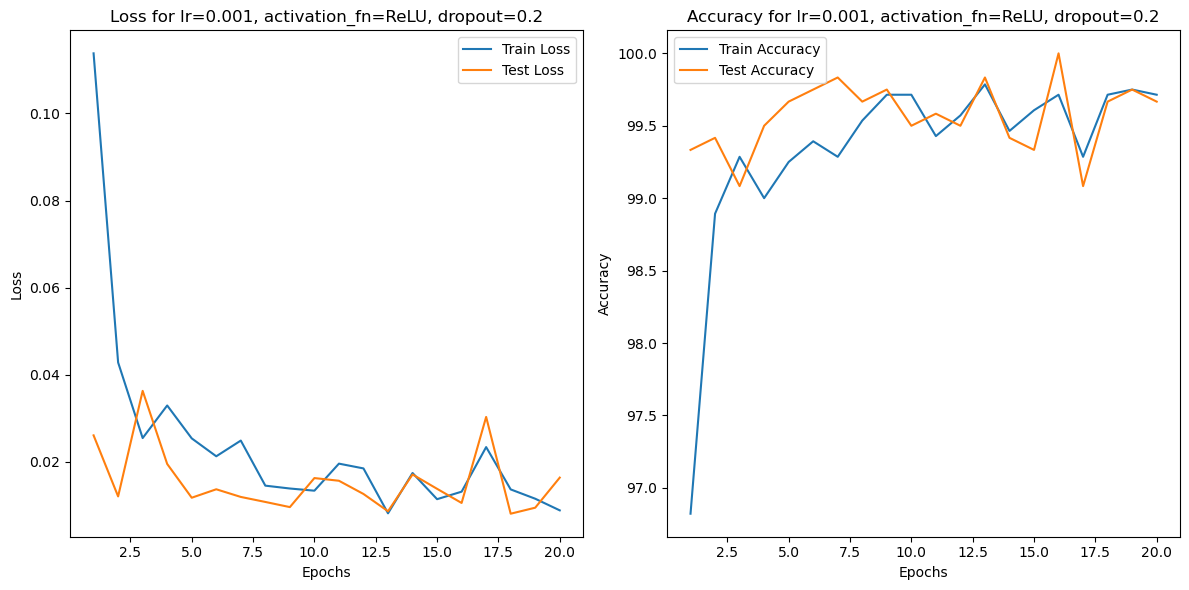


Training with lr=0.001, activation_fn=ReLU, dropout_rate=0.3
Epoch 1/20, Loss: 0.1334, Accuracy: 95.64%
Epoch 2/20, Loss: 0.0368, Accuracy: 98.86%
Epoch 3/20, Loss: 0.0315, Accuracy: 99.25%
Epoch 4/20, Loss: 0.0259, Accuracy: 99.29%
Epoch 5/20, Loss: 0.0178, Accuracy: 99.64%
Epoch 6/20, Loss: 0.0196, Accuracy: 99.29%
Epoch 7/20, Loss: 0.0205, Accuracy: 99.46%
Epoch 8/20, Loss: 0.0149, Accuracy: 99.57%
Epoch 9/20, Loss: 0.0143, Accuracy: 99.50%
Epoch 10/20, Loss: 0.0124, Accuracy: 99.64%
Epoch 11/20, Loss: 0.0193, Accuracy: 99.32%
Epoch 12/20, Loss: 0.0217, Accuracy: 99.43%
Epoch 13/20, Loss: 0.0141, Accuracy: 99.54%
Epoch 14/20, Loss: 0.0135, Accuracy: 99.57%
Epoch 15/20, Loss: 0.0110, Accuracy: 99.68%
Epoch 16/20, Loss: 0.0269, Accuracy: 99.29%
Epoch 17/20, Loss: 0.0120, Accuracy: 99.61%
Epoch 18/20, Loss: 0.0128, Accuracy: 99.64%
Epoch 19/20, Loss: 0.0124, Accuracy: 99.61%
Epoch 20/20, Loss: 0.0104, Accuracy: 99.86%

Test Accuracy: 99.67%


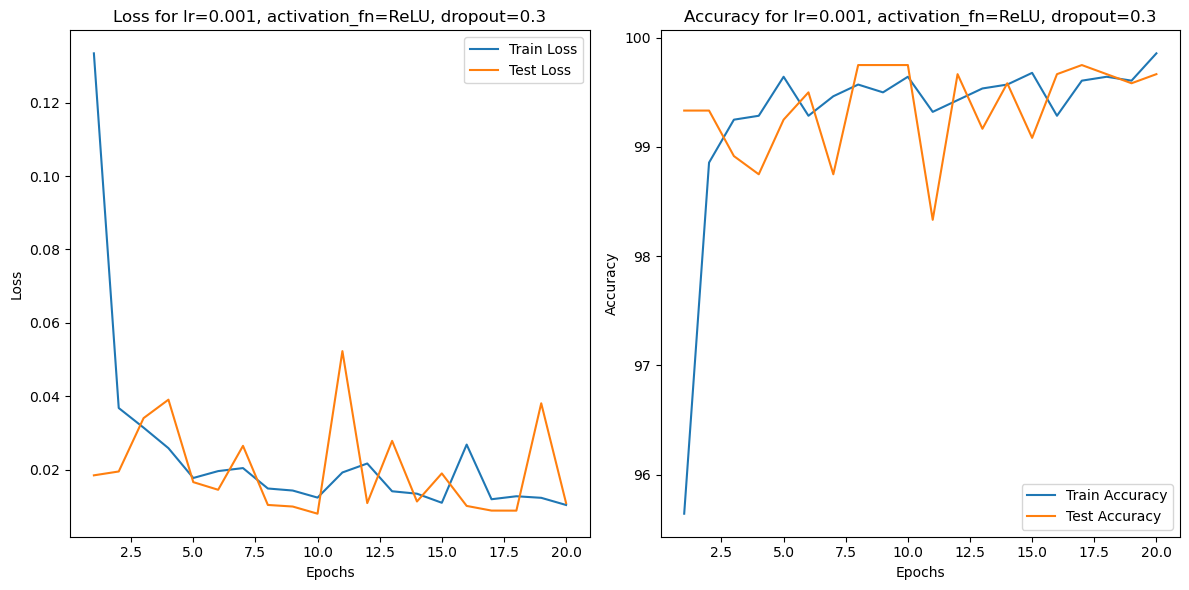


Training with lr=0.001, activation_fn=ReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.1268, Accuracy: 95.93%
Epoch 2/20, Loss: 0.0540, Accuracy: 98.79%
Epoch 3/20, Loss: 0.0306, Accuracy: 99.18%
Epoch 4/20, Loss: 0.0283, Accuracy: 99.11%
Epoch 5/20, Loss: 0.0315, Accuracy: 99.21%
Epoch 6/20, Loss: 0.0311, Accuracy: 99.14%
Epoch 7/20, Loss: 0.0263, Accuracy: 99.39%
Epoch 8/20, Loss: 0.0195, Accuracy: 99.61%
Epoch 9/20, Loss: 0.0249, Accuracy: 99.39%
Epoch 10/20, Loss: 0.0151, Accuracy: 99.61%
Epoch 11/20, Loss: 0.0230, Accuracy: 99.43%
Epoch 12/20, Loss: 0.0138, Accuracy: 99.68%
Epoch 13/20, Loss: 0.0296, Accuracy: 99.25%
Epoch 14/20, Loss: 0.0153, Accuracy: 99.57%
Epoch 15/20, Loss: 0.0167, Accuracy: 99.46%
Epoch 16/20, Loss: 0.0159, Accuracy: 99.50%
Epoch 17/20, Loss: 0.0188, Accuracy: 99.61%
Epoch 18/20, Loss: 0.0177, Accuracy: 99.54%
Epoch 19/20, Loss: 0.0184, Accuracy: 99.46%
Epoch 20/20, Loss: 0.0125, Accuracy: 99.68%

Test Accuracy: 99.50%


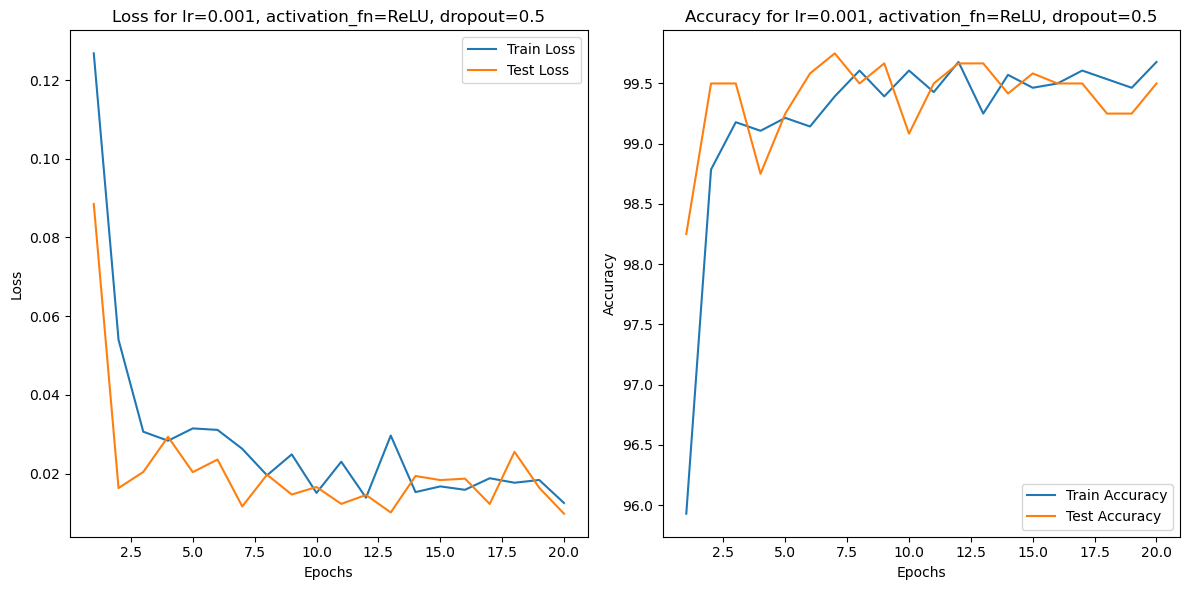


Training with lr=0.001, activation_fn=LeakyReLU, dropout_rate=0.2
Epoch 1/20, Loss: 0.1327, Accuracy: 95.54%
Epoch 2/20, Loss: 0.0447, Accuracy: 98.82%
Epoch 3/20, Loss: 0.0339, Accuracy: 99.07%
Epoch 4/20, Loss: 0.0342, Accuracy: 99.07%
Epoch 5/20, Loss: 0.0299, Accuracy: 99.36%
Epoch 6/20, Loss: 0.0180, Accuracy: 99.36%
Epoch 7/20, Loss: 0.0240, Accuracy: 99.29%
Epoch 8/20, Loss: 0.0207, Accuracy: 99.57%
Epoch 9/20, Loss: 0.0198, Accuracy: 99.43%
Epoch 10/20, Loss: 0.0202, Accuracy: 99.46%
Epoch 11/20, Loss: 0.0216, Accuracy: 99.43%
Epoch 12/20, Loss: 0.0133, Accuracy: 99.57%
Epoch 13/20, Loss: 0.0234, Accuracy: 99.39%
Epoch 14/20, Loss: 0.0136, Accuracy: 99.50%
Epoch 15/20, Loss: 0.0159, Accuracy: 99.57%
Epoch 16/20, Loss: 0.0108, Accuracy: 99.71%
Epoch 17/20, Loss: 0.0111, Accuracy: 99.61%
Epoch 18/20, Loss: 0.0248, Accuracy: 99.46%
Epoch 19/20, Loss: 0.0149, Accuracy: 99.50%
Epoch 20/20, Loss: 0.0163, Accuracy: 99.57%

Test Accuracy: 99.75%


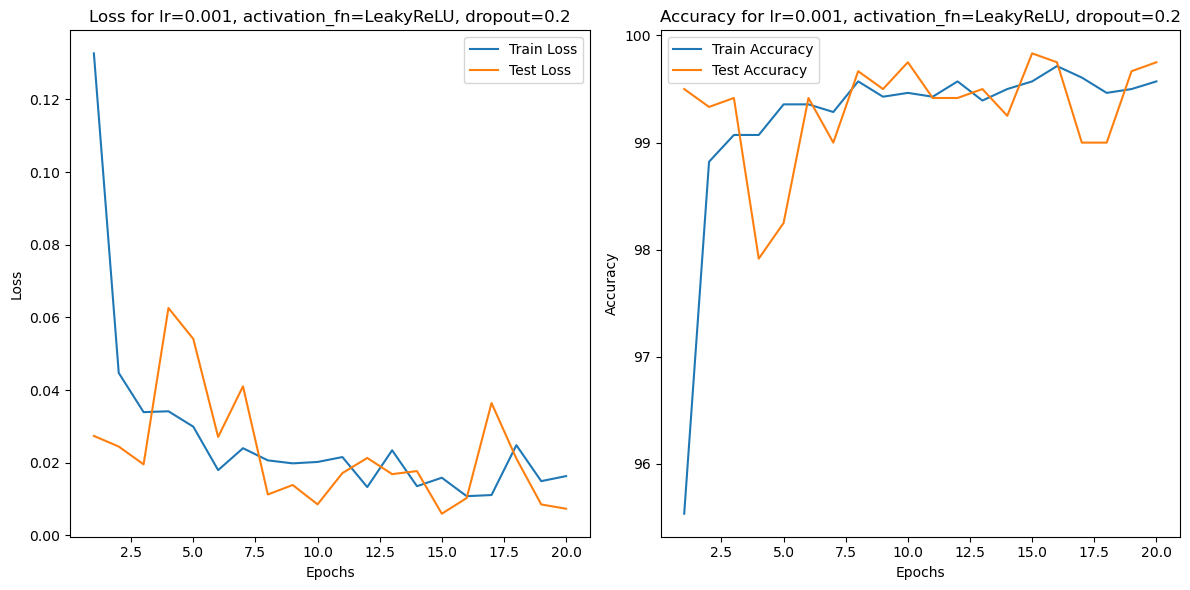


Training with lr=0.001, activation_fn=LeakyReLU, dropout_rate=0.3
Epoch 1/20, Loss: 0.1231, Accuracy: 95.71%
Epoch 2/20, Loss: 0.0485, Accuracy: 98.86%
Epoch 3/20, Loss: 0.0360, Accuracy: 99.04%
Epoch 4/20, Loss: 0.0283, Accuracy: 99.29%
Epoch 5/20, Loss: 0.0187, Accuracy: 99.57%
Epoch 6/20, Loss: 0.0239, Accuracy: 99.14%
Epoch 7/20, Loss: 0.0284, Accuracy: 99.25%
Epoch 8/20, Loss: 0.0236, Accuracy: 99.43%
Epoch 9/20, Loss: 0.0161, Accuracy: 99.50%
Epoch 10/20, Loss: 0.0196, Accuracy: 99.50%
Epoch 11/20, Loss: 0.0170, Accuracy: 99.43%
Epoch 12/20, Loss: 0.0179, Accuracy: 99.50%
Epoch 13/20, Loss: 0.0217, Accuracy: 99.39%
Epoch 14/20, Loss: 0.0104, Accuracy: 99.71%
Epoch 15/20, Loss: 0.0154, Accuracy: 99.57%
Epoch 16/20, Loss: 0.0137, Accuracy: 99.61%
Epoch 17/20, Loss: 0.0138, Accuracy: 99.68%
Epoch 18/20, Loss: 0.0180, Accuracy: 99.50%
Epoch 19/20, Loss: 0.0152, Accuracy: 99.36%
Epoch 20/20, Loss: 0.0136, Accuracy: 99.64%

Test Accuracy: 99.50%


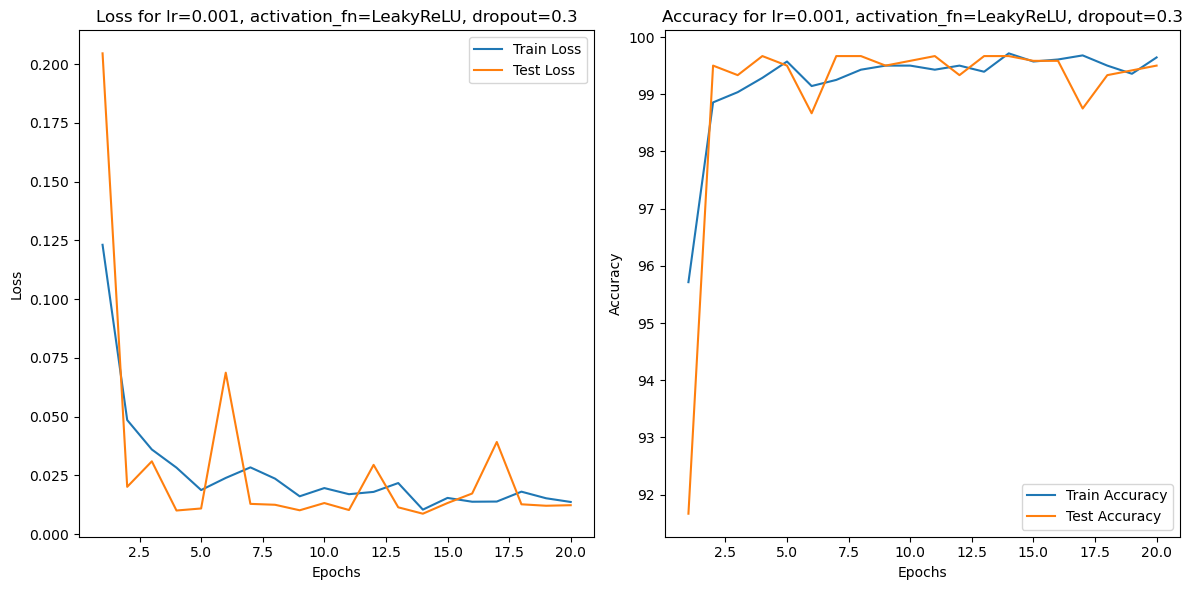


Training with lr=0.001, activation_fn=LeakyReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.1129, Accuracy: 96.25%
Epoch 2/20, Loss: 0.0328, Accuracy: 99.00%
Epoch 3/20, Loss: 0.0372, Accuracy: 99.04%
Epoch 4/20, Loss: 0.0240, Accuracy: 99.32%
Epoch 5/20, Loss: 0.0242, Accuracy: 99.46%
Epoch 6/20, Loss: 0.0261, Accuracy: 99.07%
Epoch 7/20, Loss: 0.0212, Accuracy: 99.43%
Epoch 8/20, Loss: 0.0220, Accuracy: 99.32%
Epoch 9/20, Loss: 0.0246, Accuracy: 99.14%
Epoch 10/20, Loss: 0.0206, Accuracy: 99.43%
Epoch 11/20, Loss: 0.0172, Accuracy: 99.50%
Epoch 12/20, Loss: 0.0227, Accuracy: 99.36%
Epoch 13/20, Loss: 0.0139, Accuracy: 99.75%
Epoch 14/20, Loss: 0.0174, Accuracy: 99.46%
Epoch 15/20, Loss: 0.0155, Accuracy: 99.43%
Epoch 16/20, Loss: 0.0278, Accuracy: 99.11%
Epoch 17/20, Loss: 0.0151, Accuracy: 99.64%
Epoch 18/20, Loss: 0.0169, Accuracy: 99.36%
Epoch 19/20, Loss: 0.0183, Accuracy: 99.50%
Epoch 20/20, Loss: 0.0207, Accuracy: 99.32%

Test Accuracy: 99.42%


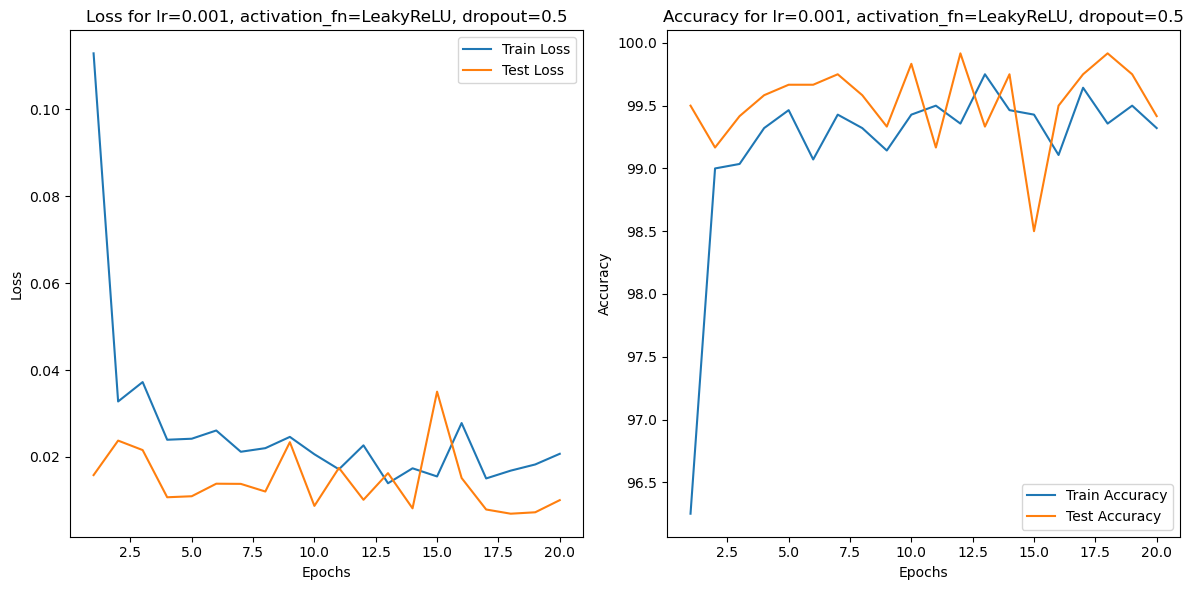


Training with lr=0.001, activation_fn=ELU, dropout_rate=0.2
Epoch 1/20, Loss: 0.1128, Accuracy: 96.79%
Epoch 2/20, Loss: 0.0382, Accuracy: 98.79%
Epoch 3/20, Loss: 0.0289, Accuracy: 99.21%
Epoch 4/20, Loss: 0.0341, Accuracy: 99.07%
Epoch 5/20, Loss: 0.0309, Accuracy: 99.04%
Epoch 6/20, Loss: 0.0172, Accuracy: 99.57%
Epoch 7/20, Loss: 0.0282, Accuracy: 99.25%
Epoch 8/20, Loss: 0.0303, Accuracy: 98.96%
Epoch 9/20, Loss: 0.0228, Accuracy: 99.29%
Epoch 10/20, Loss: 0.0179, Accuracy: 99.43%
Epoch 11/20, Loss: 0.0130, Accuracy: 99.68%
Epoch 12/20, Loss: 0.0337, Accuracy: 98.82%
Epoch 13/20, Loss: 0.0126, Accuracy: 99.64%
Epoch 14/20, Loss: 0.0171, Accuracy: 99.36%
Epoch 15/20, Loss: 0.0133, Accuracy: 99.64%
Epoch 16/20, Loss: 0.0084, Accuracy: 99.82%
Epoch 17/20, Loss: 0.0287, Accuracy: 99.32%
Epoch 18/20, Loss: 0.0338, Accuracy: 99.07%
Epoch 19/20, Loss: 0.0127, Accuracy: 99.64%
Epoch 20/20, Loss: 0.0106, Accuracy: 99.75%

Test Accuracy: 99.42%


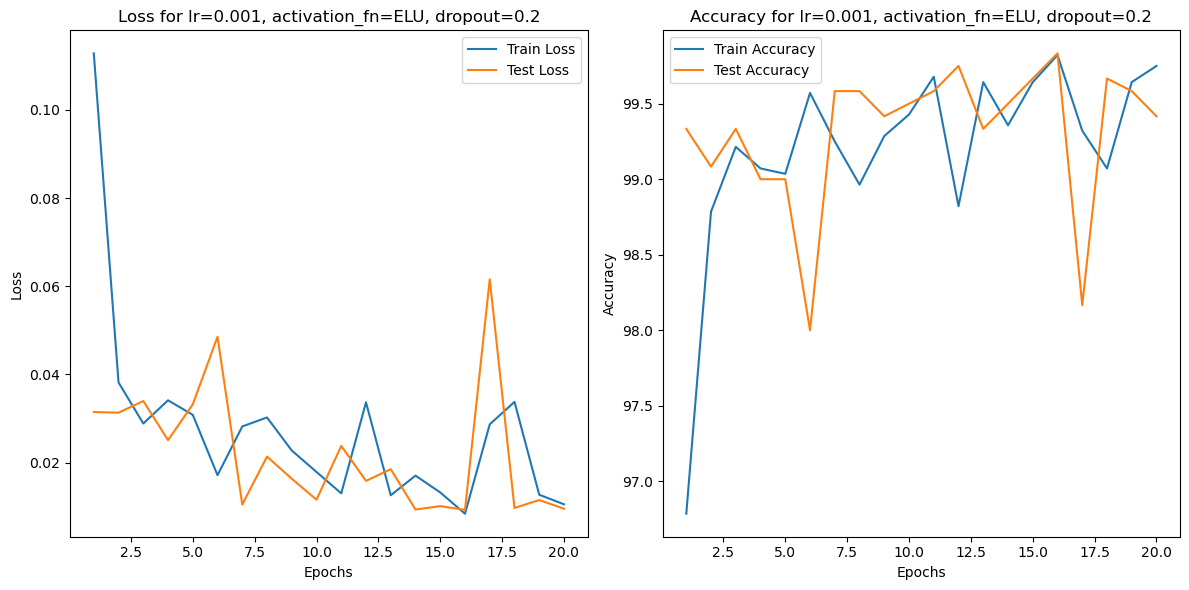


Training with lr=0.001, activation_fn=ELU, dropout_rate=0.3
Epoch 1/20, Loss: 0.1078, Accuracy: 96.79%
Epoch 2/20, Loss: 0.0272, Accuracy: 99.07%
Epoch 3/20, Loss: 0.0432, Accuracy: 98.79%
Epoch 4/20, Loss: 0.0300, Accuracy: 99.14%
Epoch 5/20, Loss: 0.0217, Accuracy: 99.50%
Epoch 6/20, Loss: 0.0152, Accuracy: 99.54%
Epoch 7/20, Loss: 0.0186, Accuracy: 99.50%
Epoch 8/20, Loss: 0.0204, Accuracy: 99.29%
Epoch 9/20, Loss: 0.0162, Accuracy: 99.46%
Epoch 10/20, Loss: 0.0147, Accuracy: 99.57%
Epoch 11/20, Loss: 0.0127, Accuracy: 99.79%
Epoch 12/20, Loss: 0.0122, Accuracy: 99.64%
Epoch 13/20, Loss: 0.0168, Accuracy: 99.50%
Epoch 14/20, Loss: 0.0096, Accuracy: 99.71%
Epoch 15/20, Loss: 0.0109, Accuracy: 99.57%
Epoch 16/20, Loss: 0.0168, Accuracy: 99.43%
Epoch 17/20, Loss: 0.0111, Accuracy: 99.71%
Epoch 18/20, Loss: 0.0115, Accuracy: 99.64%
Epoch 19/20, Loss: 0.0109, Accuracy: 99.75%
Epoch 20/20, Loss: 0.0138, Accuracy: 99.64%

Test Accuracy: 99.75%


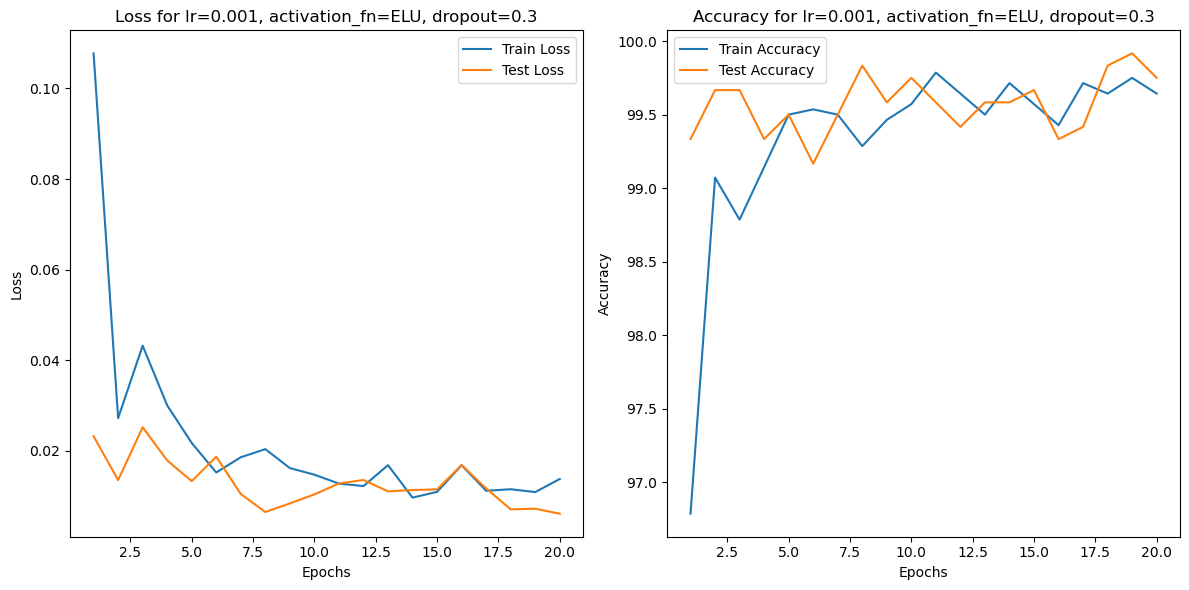


Training with lr=0.001, activation_fn=ELU, dropout_rate=0.5
Epoch 1/20, Loss: 0.1088, Accuracy: 96.93%
Epoch 2/20, Loss: 0.0341, Accuracy: 99.07%
Epoch 3/20, Loss: 0.0388, Accuracy: 99.04%
Epoch 4/20, Loss: 0.0235, Accuracy: 99.14%
Epoch 5/20, Loss: 0.0356, Accuracy: 99.07%
Epoch 6/20, Loss: 0.0174, Accuracy: 99.39%
Epoch 7/20, Loss: 0.0252, Accuracy: 99.54%
Epoch 8/20, Loss: 0.0155, Accuracy: 99.54%
Epoch 9/20, Loss: 0.0250, Accuracy: 99.25%
Epoch 10/20, Loss: 0.0164, Accuracy: 99.57%
Epoch 11/20, Loss: 0.0182, Accuracy: 99.46%
Epoch 12/20, Loss: 0.0170, Accuracy: 99.46%
Epoch 13/20, Loss: 0.0168, Accuracy: 99.57%
Epoch 14/20, Loss: 0.0143, Accuracy: 99.50%
Epoch 15/20, Loss: 0.0194, Accuracy: 99.43%
Epoch 16/20, Loss: 0.0161, Accuracy: 99.57%
Epoch 17/20, Loss: 0.0193, Accuracy: 99.54%
Epoch 18/20, Loss: 0.0109, Accuracy: 99.79%
Epoch 19/20, Loss: 0.0181, Accuracy: 99.57%
Epoch 20/20, Loss: 0.0166, Accuracy: 99.50%

Test Accuracy: 99.75%


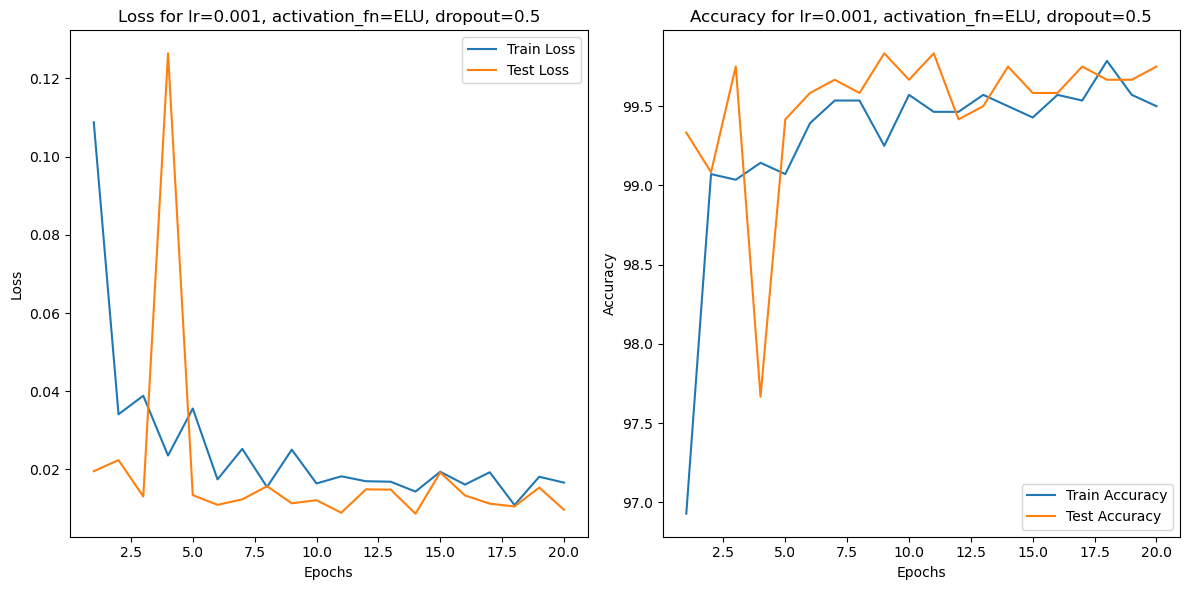


Training with lr=0.0001, activation_fn=ReLU, dropout_rate=0.2
Epoch 1/20, Loss: 0.2434, Accuracy: 94.79%
Epoch 2/20, Loss: 0.0340, Accuracy: 99.14%
Epoch 3/20, Loss: 0.0295, Accuracy: 99.18%
Epoch 4/20, Loss: 0.0181, Accuracy: 99.64%
Epoch 5/20, Loss: 0.0240, Accuracy: 99.32%
Epoch 6/20, Loss: 0.0178, Accuracy: 99.43%
Epoch 7/20, Loss: 0.0173, Accuracy: 99.54%
Epoch 8/20, Loss: 0.0147, Accuracy: 99.61%
Epoch 9/20, Loss: 0.0190, Accuracy: 99.50%
Epoch 10/20, Loss: 0.0141, Accuracy: 99.50%
Epoch 11/20, Loss: 0.0086, Accuracy: 99.89%
Epoch 12/20, Loss: 0.0107, Accuracy: 99.79%
Epoch 13/20, Loss: 0.0131, Accuracy: 99.68%
Epoch 14/20, Loss: 0.0162, Accuracy: 99.36%
Epoch 15/20, Loss: 0.0098, Accuracy: 99.71%
Epoch 16/20, Loss: 0.0142, Accuracy: 99.57%
Epoch 17/20, Loss: 0.0047, Accuracy: 99.93%
Epoch 18/20, Loss: 0.0213, Accuracy: 99.43%
Epoch 19/20, Loss: 0.0122, Accuracy: 99.75%
Epoch 20/20, Loss: 0.0135, Accuracy: 99.43%

Test Accuracy: 99.50%


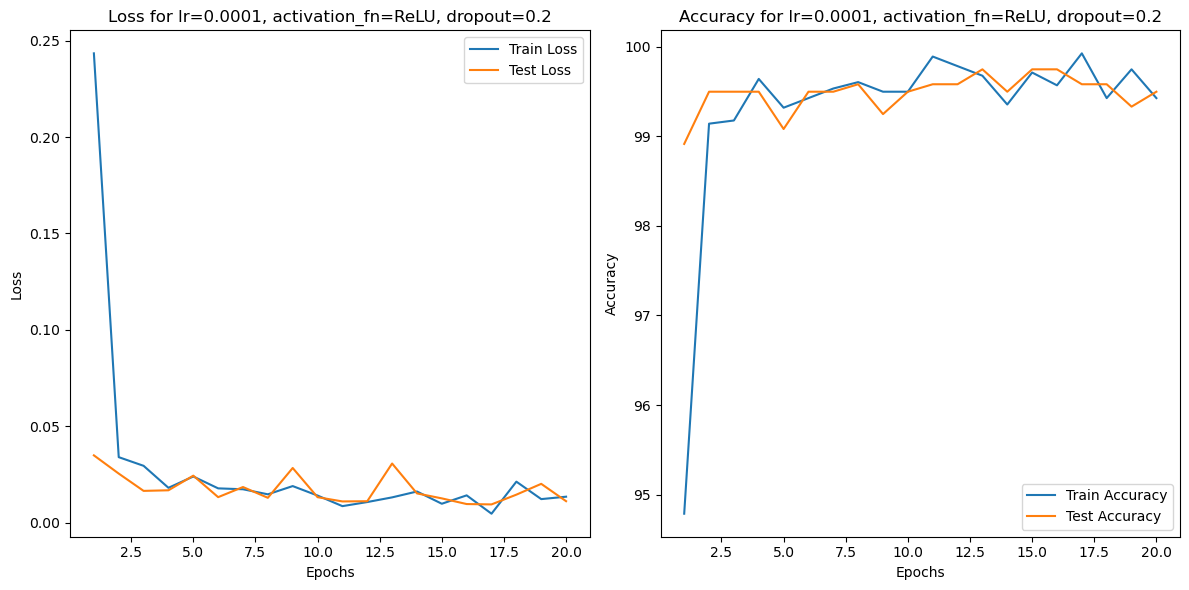


Training with lr=0.0001, activation_fn=ReLU, dropout_rate=0.3
Epoch 1/20, Loss: 0.2838, Accuracy: 91.75%
Epoch 2/20, Loss: 0.0375, Accuracy: 98.93%
Epoch 3/20, Loss: 0.0257, Accuracy: 99.39%
Epoch 4/20, Loss: 0.0202, Accuracy: 99.46%
Epoch 5/20, Loss: 0.0212, Accuracy: 99.46%
Epoch 6/20, Loss: 0.0224, Accuracy: 99.29%
Epoch 7/20, Loss: 0.0208, Accuracy: 99.57%
Epoch 8/20, Loss: 0.0163, Accuracy: 99.46%
Epoch 9/20, Loss: 0.0174, Accuracy: 99.50%
Epoch 10/20, Loss: 0.0134, Accuracy: 99.64%
Epoch 11/20, Loss: 0.0146, Accuracy: 99.50%
Epoch 12/20, Loss: 0.0168, Accuracy: 99.50%
Epoch 13/20, Loss: 0.0101, Accuracy: 99.71%
Epoch 14/20, Loss: 0.0113, Accuracy: 99.71%
Epoch 15/20, Loss: 0.0227, Accuracy: 99.21%
Epoch 16/20, Loss: 0.0134, Accuracy: 99.50%
Epoch 17/20, Loss: 0.0086, Accuracy: 99.89%
Epoch 18/20, Loss: 0.0093, Accuracy: 99.79%
Epoch 19/20, Loss: 0.0135, Accuracy: 99.61%
Epoch 20/20, Loss: 0.0143, Accuracy: 99.54%

Test Accuracy: 99.67%


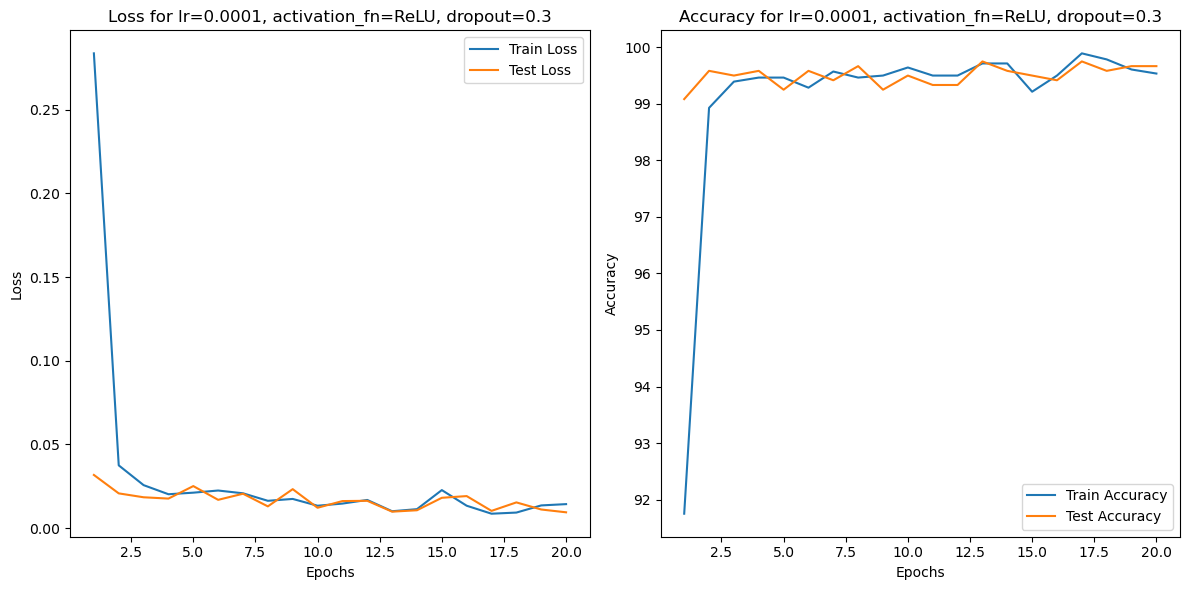


Training with lr=0.0001, activation_fn=ReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.3091, Accuracy: 91.18%
Epoch 2/20, Loss: 0.0379, Accuracy: 98.93%
Epoch 3/20, Loss: 0.0320, Accuracy: 99.18%
Epoch 4/20, Loss: 0.0266, Accuracy: 99.29%
Epoch 5/20, Loss: 0.0238, Accuracy: 99.46%
Epoch 6/20, Loss: 0.0164, Accuracy: 99.54%
Epoch 7/20, Loss: 0.0226, Accuracy: 99.21%
Epoch 8/20, Loss: 0.0204, Accuracy: 99.43%
Epoch 9/20, Loss: 0.0149, Accuracy: 99.57%
Epoch 10/20, Loss: 0.0213, Accuracy: 99.32%
Epoch 11/20, Loss: 0.0158, Accuracy: 99.57%
Epoch 12/20, Loss: 0.0142, Accuracy: 99.57%
Epoch 13/20, Loss: 0.0168, Accuracy: 99.57%
Epoch 14/20, Loss: 0.0153, Accuracy: 99.64%
Epoch 15/20, Loss: 0.0217, Accuracy: 99.32%
Epoch 16/20, Loss: 0.0191, Accuracy: 99.43%
Epoch 17/20, Loss: 0.0106, Accuracy: 99.75%
Epoch 18/20, Loss: 0.0139, Accuracy: 99.71%
Epoch 19/20, Loss: 0.0120, Accuracy: 99.64%
Epoch 20/20, Loss: 0.0120, Accuracy: 99.64%

Test Accuracy: 99.67%


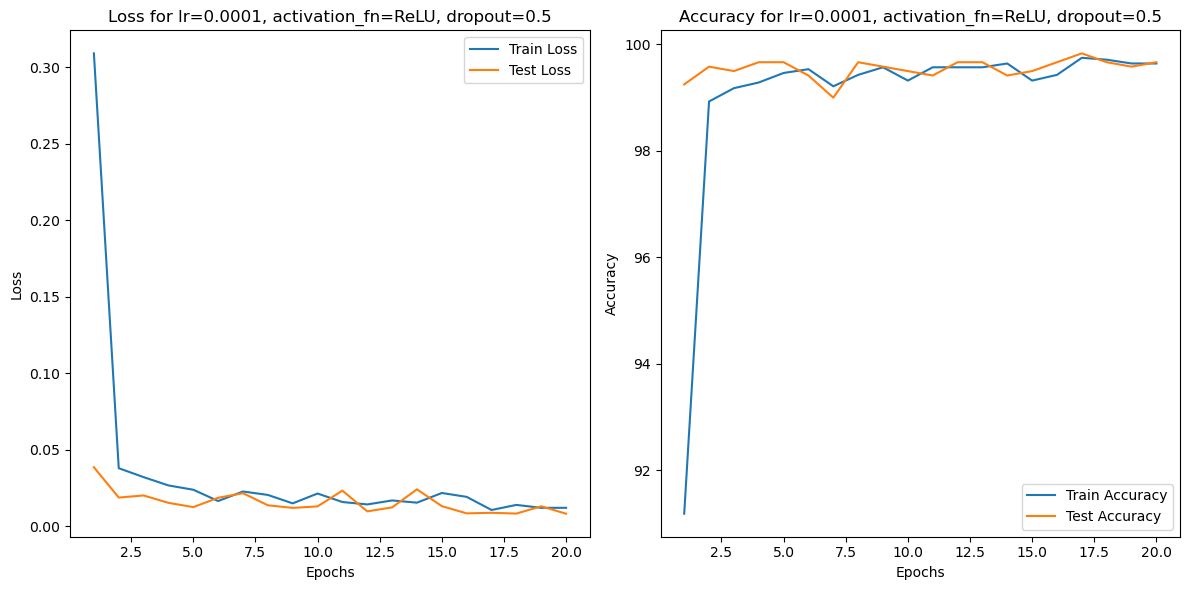


Training with lr=0.0001, activation_fn=LeakyReLU, dropout_rate=0.2
Epoch 1/20, Loss: 0.2464, Accuracy: 93.21%
Epoch 2/20, Loss: 0.0301, Accuracy: 99.39%
Epoch 3/20, Loss: 0.0282, Accuracy: 99.18%
Epoch 4/20, Loss: 0.0174, Accuracy: 99.57%
Epoch 5/20, Loss: 0.0202, Accuracy: 99.43%
Epoch 6/20, Loss: 0.0253, Accuracy: 99.32%
Epoch 7/20, Loss: 0.0140, Accuracy: 99.64%
Epoch 8/20, Loss: 0.0201, Accuracy: 99.46%
Epoch 9/20, Loss: 0.0121, Accuracy: 99.61%
Epoch 10/20, Loss: 0.0105, Accuracy: 99.71%
Epoch 11/20, Loss: 0.0103, Accuracy: 99.82%
Epoch 12/20, Loss: 0.0166, Accuracy: 99.46%
Epoch 13/20, Loss: 0.0108, Accuracy: 99.68%
Epoch 14/20, Loss: 0.0106, Accuracy: 99.79%
Epoch 15/20, Loss: 0.0153, Accuracy: 99.57%
Epoch 16/20, Loss: 0.0084, Accuracy: 99.68%
Epoch 17/20, Loss: 0.0128, Accuracy: 99.61%
Epoch 18/20, Loss: 0.0089, Accuracy: 99.79%
Epoch 19/20, Loss: 0.0203, Accuracy: 99.39%
Epoch 20/20, Loss: 0.0101, Accuracy: 99.71%

Test Accuracy: 99.58%


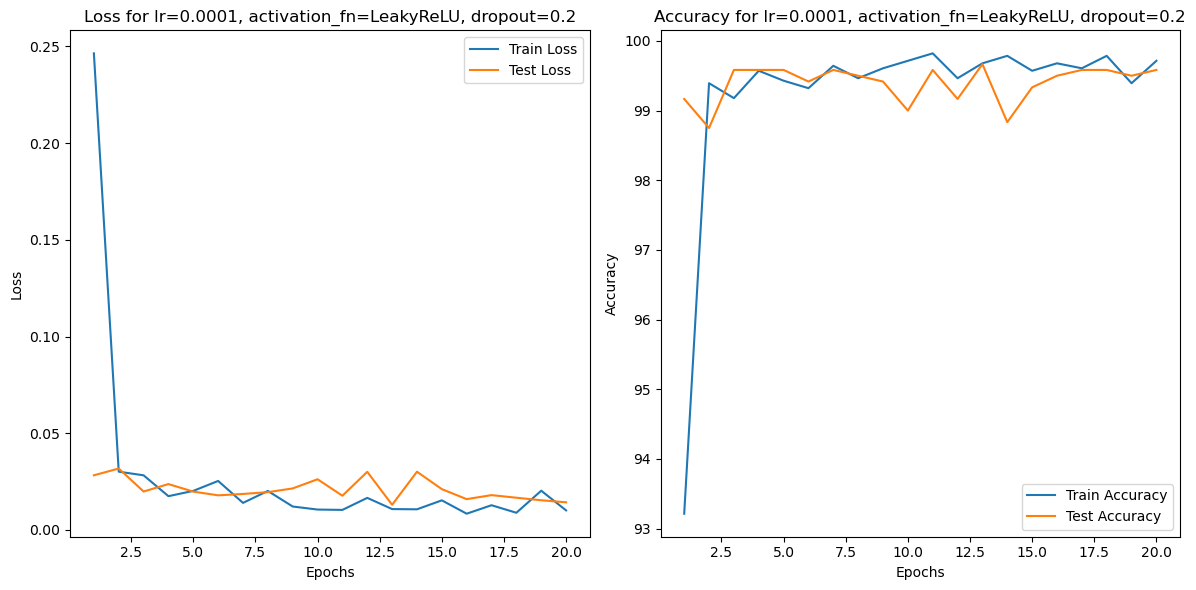


Training with lr=0.0001, activation_fn=LeakyReLU, dropout_rate=0.3
Epoch 1/20, Loss: 0.2321, Accuracy: 96.32%
Epoch 2/20, Loss: 0.0313, Accuracy: 99.21%
Epoch 3/20, Loss: 0.0244, Accuracy: 99.39%
Epoch 4/20, Loss: 0.0253, Accuracy: 99.29%
Epoch 5/20, Loss: 0.0218, Accuracy: 99.54%
Epoch 6/20, Loss: 0.0222, Accuracy: 99.46%
Epoch 7/20, Loss: 0.0142, Accuracy: 99.57%
Epoch 8/20, Loss: 0.0138, Accuracy: 99.57%
Epoch 9/20, Loss: 0.0187, Accuracy: 99.43%
Epoch 10/20, Loss: 0.0102, Accuracy: 99.71%
Epoch 11/20, Loss: 0.0143, Accuracy: 99.64%
Epoch 12/20, Loss: 0.0100, Accuracy: 99.68%
Epoch 13/20, Loss: 0.0135, Accuracy: 99.64%
Epoch 14/20, Loss: 0.0131, Accuracy: 99.46%
Epoch 15/20, Loss: 0.0135, Accuracy: 99.50%
Epoch 16/20, Loss: 0.0103, Accuracy: 99.68%
Epoch 17/20, Loss: 0.0140, Accuracy: 99.68%
Epoch 18/20, Loss: 0.0124, Accuracy: 99.68%
Epoch 19/20, Loss: 0.0115, Accuracy: 99.54%
Epoch 20/20, Loss: 0.0111, Accuracy: 99.79%

Test Accuracy: 99.67%


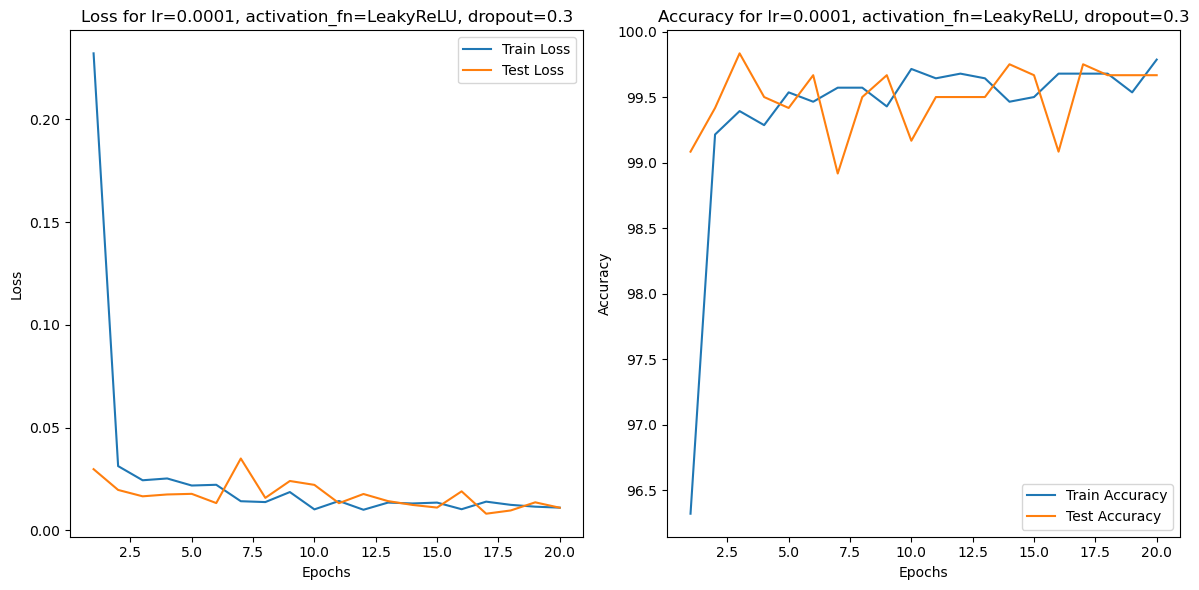


Training with lr=0.0001, activation_fn=LeakyReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.2773, Accuracy: 93.07%
Epoch 2/20, Loss: 0.0394, Accuracy: 98.82%
Epoch 3/20, Loss: 0.0352, Accuracy: 99.18%
Epoch 4/20, Loss: 0.0308, Accuracy: 99.14%
Epoch 5/20, Loss: 0.0264, Accuracy: 99.14%
Epoch 6/20, Loss: 0.0251, Accuracy: 99.39%
Epoch 7/20, Loss: 0.0274, Accuracy: 98.93%
Epoch 8/20, Loss: 0.0210, Accuracy: 99.39%
Epoch 9/20, Loss: 0.0138, Accuracy: 99.57%
Epoch 10/20, Loss: 0.0204, Accuracy: 99.36%
Epoch 11/20, Loss: 0.0132, Accuracy: 99.64%
Epoch 12/20, Loss: 0.0163, Accuracy: 99.61%
Epoch 13/20, Loss: 0.0188, Accuracy: 99.46%
Epoch 14/20, Loss: 0.0137, Accuracy: 99.61%
Epoch 15/20, Loss: 0.0129, Accuracy: 99.57%
Epoch 16/20, Loss: 0.0188, Accuracy: 99.57%
Epoch 17/20, Loss: 0.0176, Accuracy: 99.54%
Epoch 18/20, Loss: 0.0108, Accuracy: 99.64%
Epoch 19/20, Loss: 0.0203, Accuracy: 99.36%
Epoch 20/20, Loss: 0.0137, Accuracy: 99.57%

Test Accuracy: 99.50%


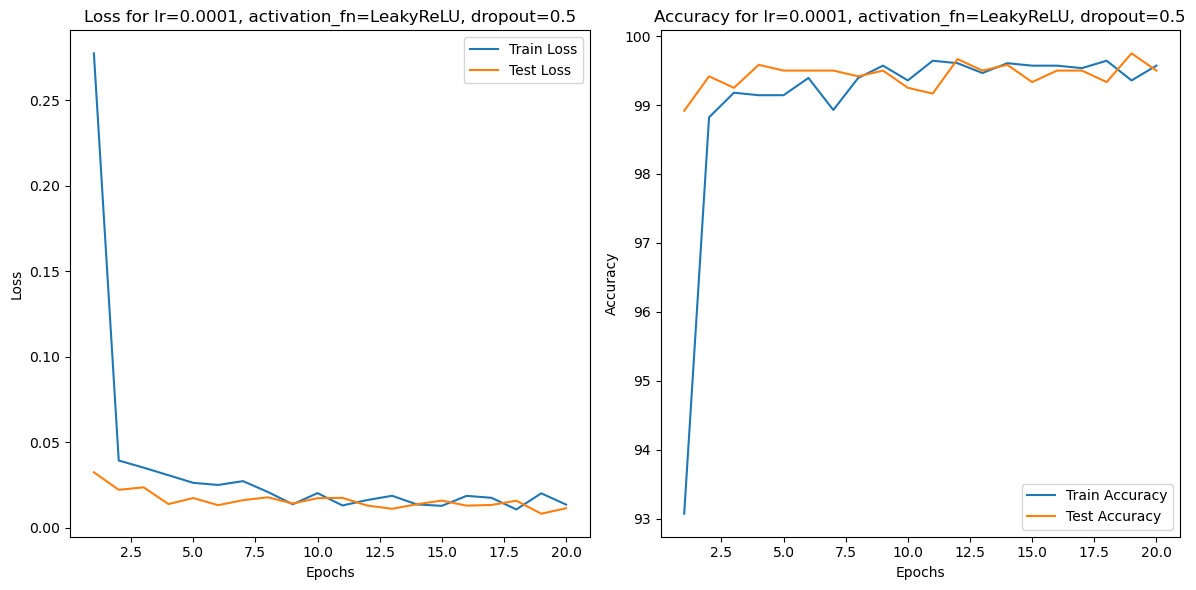


Training with lr=0.0001, activation_fn=ELU, dropout_rate=0.2
Epoch 1/20, Loss: 0.1284, Accuracy: 95.79%
Epoch 2/20, Loss: 0.0240, Accuracy: 99.54%
Epoch 3/20, Loss: 0.0273, Accuracy: 99.04%
Epoch 4/20, Loss: 0.0179, Accuracy: 99.50%
Epoch 5/20, Loss: 0.0184, Accuracy: 99.57%
Epoch 6/20, Loss: 0.0180, Accuracy: 99.57%
Epoch 7/20, Loss: 0.0224, Accuracy: 99.46%
Epoch 8/20, Loss: 0.0122, Accuracy: 99.71%
Epoch 9/20, Loss: 0.0125, Accuracy: 99.61%
Epoch 10/20, Loss: 0.0110, Accuracy: 99.71%
Epoch 11/20, Loss: 0.0086, Accuracy: 99.68%
Epoch 12/20, Loss: 0.0109, Accuracy: 99.79%
Epoch 13/20, Loss: 0.0083, Accuracy: 99.79%
Epoch 14/20, Loss: 0.0154, Accuracy: 99.68%
Epoch 15/20, Loss: 0.0127, Accuracy: 99.68%
Epoch 16/20, Loss: 0.0083, Accuracy: 99.68%
Epoch 17/20, Loss: 0.0121, Accuracy: 99.46%
Epoch 18/20, Loss: 0.0055, Accuracy: 99.89%
Epoch 19/20, Loss: 0.0100, Accuracy: 99.75%
Epoch 20/20, Loss: 0.0077, Accuracy: 99.82%

Test Accuracy: 99.58%


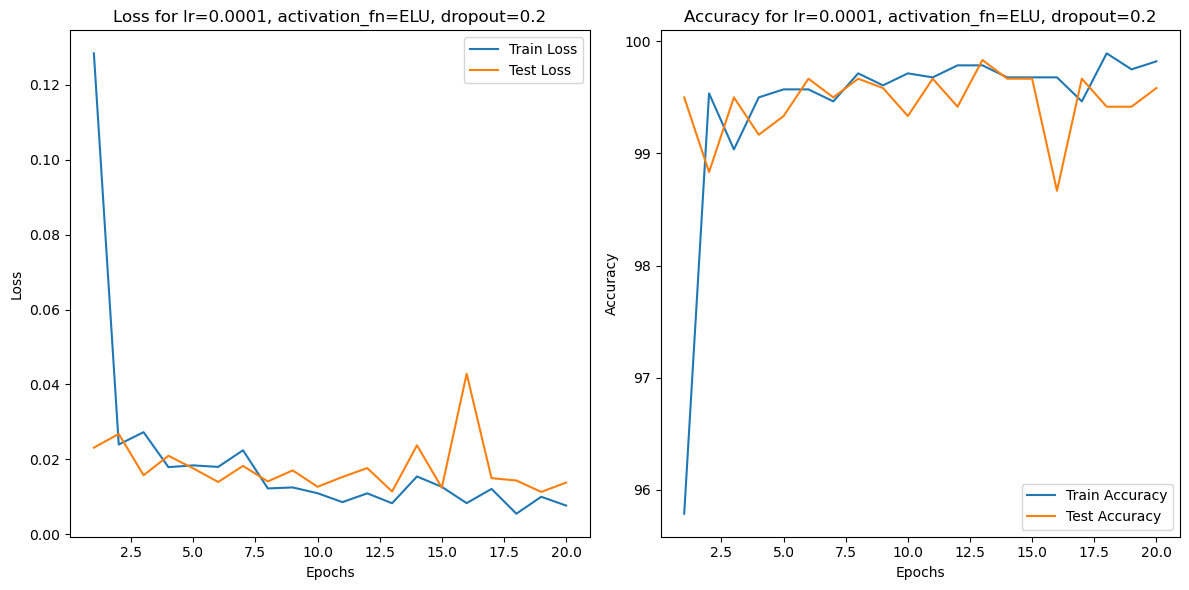


Training with lr=0.0001, activation_fn=ELU, dropout_rate=0.3
Epoch 1/20, Loss: 0.1249, Accuracy: 96.32%
Epoch 2/20, Loss: 0.0235, Accuracy: 99.54%
Epoch 3/20, Loss: 0.0237, Accuracy: 99.32%
Epoch 4/20, Loss: 0.0160, Accuracy: 99.50%
Epoch 5/20, Loss: 0.0120, Accuracy: 99.86%
Epoch 6/20, Loss: 0.0191, Accuracy: 99.39%
Epoch 7/20, Loss: 0.0121, Accuracy: 99.71%
Epoch 8/20, Loss: 0.0131, Accuracy: 99.64%
Epoch 9/20, Loss: 0.0136, Accuracy: 99.50%
Epoch 10/20, Loss: 0.0130, Accuracy: 99.61%
Epoch 11/20, Loss: 0.0173, Accuracy: 99.54%
Epoch 12/20, Loss: 0.0113, Accuracy: 99.57%
Epoch 13/20, Loss: 0.0115, Accuracy: 99.61%
Epoch 14/20, Loss: 0.0062, Accuracy: 99.89%
Epoch 15/20, Loss: 0.0109, Accuracy: 99.64%
Epoch 16/20, Loss: 0.0086, Accuracy: 99.75%
Epoch 17/20, Loss: 0.0104, Accuracy: 99.75%
Epoch 18/20, Loss: 0.0072, Accuracy: 99.71%
Epoch 19/20, Loss: 0.0111, Accuracy: 99.64%
Epoch 20/20, Loss: 0.0086, Accuracy: 99.86%

Test Accuracy: 99.50%


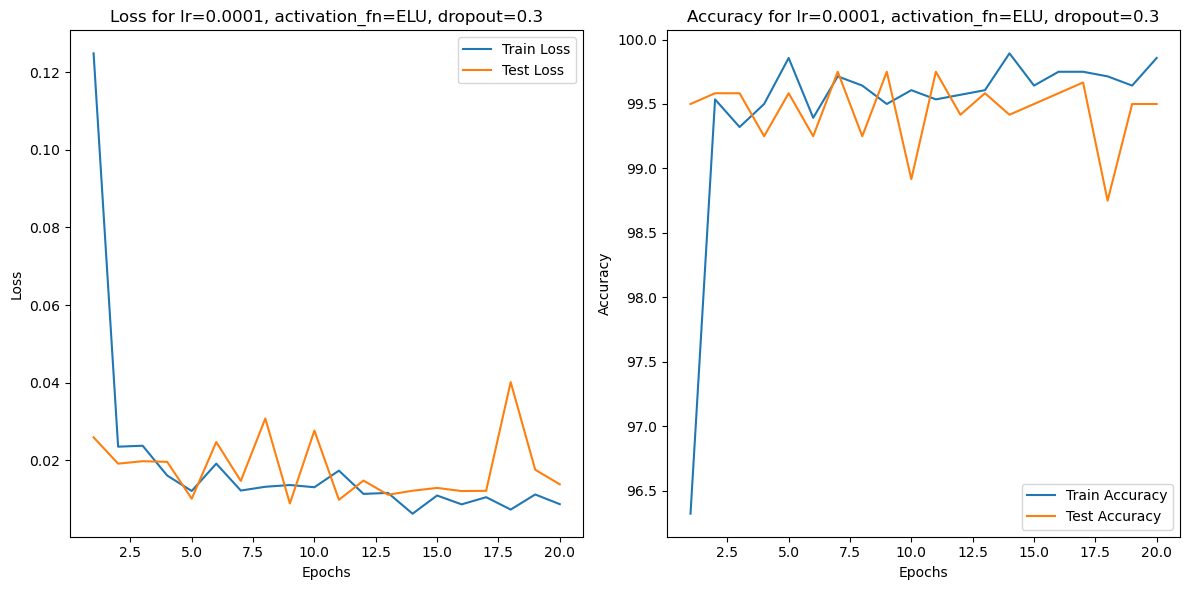


Training with lr=0.0001, activation_fn=ELU, dropout_rate=0.5
Epoch 1/20, Loss: 0.1384, Accuracy: 96.04%
Epoch 2/20, Loss: 0.0317, Accuracy: 99.11%
Epoch 3/20, Loss: 0.0232, Accuracy: 99.29%
Epoch 4/20, Loss: 0.0201, Accuracy: 99.57%
Epoch 5/20, Loss: 0.0207, Accuracy: 99.36%
Epoch 6/20, Loss: 0.0224, Accuracy: 99.50%
Epoch 7/20, Loss: 0.0139, Accuracy: 99.64%
Epoch 8/20, Loss: 0.0176, Accuracy: 99.46%
Epoch 9/20, Loss: 0.0108, Accuracy: 99.71%
Epoch 10/20, Loss: 0.0134, Accuracy: 99.57%
Epoch 11/20, Loss: 0.0132, Accuracy: 99.68%
Epoch 12/20, Loss: 0.0138, Accuracy: 99.39%
Epoch 13/20, Loss: 0.0141, Accuracy: 99.61%
Epoch 14/20, Loss: 0.0107, Accuracy: 99.71%
Epoch 15/20, Loss: 0.0081, Accuracy: 99.86%
Epoch 16/20, Loss: 0.0132, Accuracy: 99.64%
Epoch 17/20, Loss: 0.0103, Accuracy: 99.71%
Epoch 18/20, Loss: 0.0125, Accuracy: 99.61%
Epoch 19/20, Loss: 0.0094, Accuracy: 99.82%
Epoch 20/20, Loss: 0.0131, Accuracy: 99.57%

Test Accuracy: 99.50%


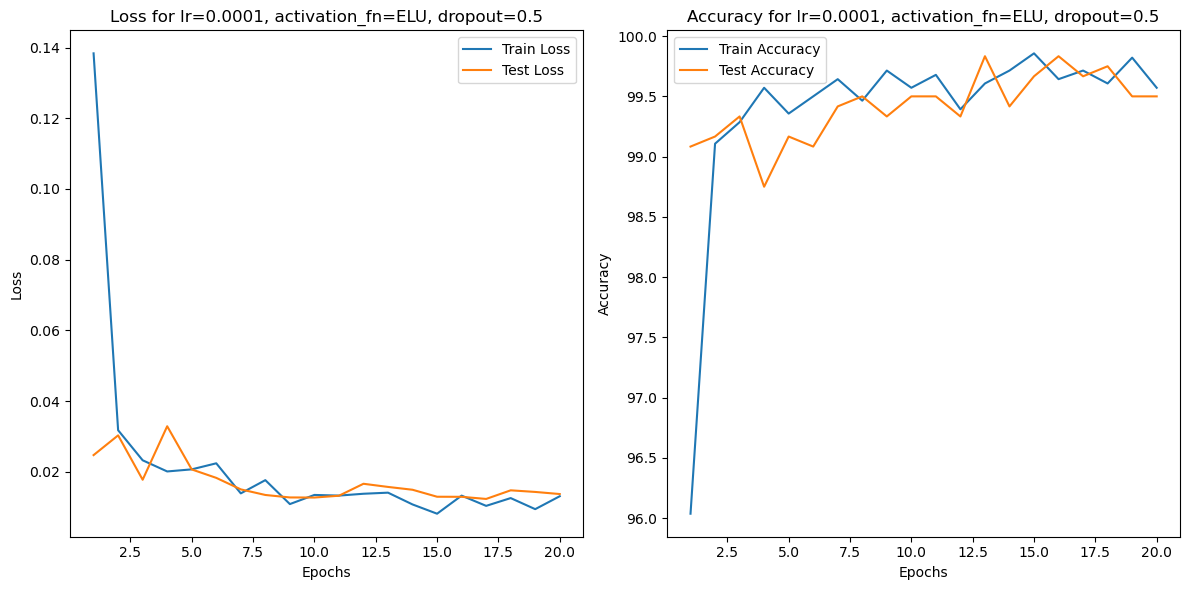


Training with lr=0.01, activation_fn=ReLU, dropout_rate=0.2
Epoch 1/20, Loss: 1.5061, Accuracy: 91.54%
Epoch 2/20, Loss: 0.1487, Accuracy: 96.68%
Epoch 3/20, Loss: 0.0869, Accuracy: 97.46%
Epoch 4/20, Loss: 0.0834, Accuracy: 98.04%
Epoch 5/20, Loss: 0.0565, Accuracy: 98.46%
Epoch 6/20, Loss: 0.0679, Accuracy: 98.18%
Epoch 7/20, Loss: 0.0390, Accuracy: 98.96%
Epoch 8/20, Loss: 0.0459, Accuracy: 98.64%
Epoch 9/20, Loss: 0.0490, Accuracy: 98.46%
Epoch 10/20, Loss: 0.0380, Accuracy: 98.93%
Epoch 11/20, Loss: 0.0399, Accuracy: 98.79%
Epoch 12/20, Loss: 0.0489, Accuracy: 98.64%
Epoch 13/20, Loss: 0.0444, Accuracy: 98.68%
Epoch 14/20, Loss: 0.0900, Accuracy: 97.75%
Epoch 15/20, Loss: 0.0495, Accuracy: 98.75%
Epoch 16/20, Loss: 0.0353, Accuracy: 99.04%
Epoch 17/20, Loss: 0.0494, Accuracy: 98.54%
Epoch 18/20, Loss: 1.2539, Accuracy: 84.50%
Epoch 19/20, Loss: 0.2402, Accuracy: 95.43%
Epoch 20/20, Loss: 0.0794, Accuracy: 97.61%

Test Accuracy: 98.42%


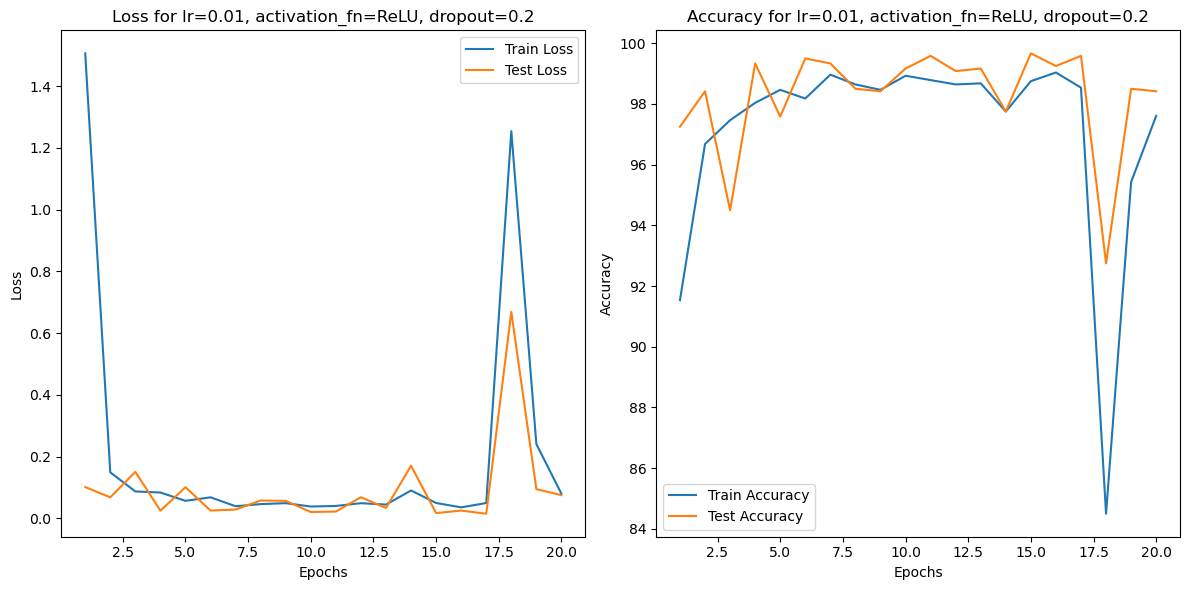


Training with lr=0.01, activation_fn=ReLU, dropout_rate=0.3
Epoch 1/20, Loss: 0.8586, Accuracy: 87.61%
Epoch 2/20, Loss: 0.1588, Accuracy: 96.50%
Epoch 3/20, Loss: 0.0755, Accuracy: 98.25%
Epoch 4/20, Loss: 0.1156, Accuracy: 97.36%
Epoch 5/20, Loss: 0.0455, Accuracy: 98.61%
Epoch 6/20, Loss: 0.0625, Accuracy: 98.14%
Epoch 7/20, Loss: 0.0598, Accuracy: 98.36%
Epoch 8/20, Loss: 0.0423, Accuracy: 99.11%
Epoch 9/20, Loss: 0.0527, Accuracy: 98.75%
Epoch 10/20, Loss: 0.0976, Accuracy: 97.46%
Epoch 11/20, Loss: 0.0944, Accuracy: 97.50%
Epoch 12/20, Loss: 0.0614, Accuracy: 98.25%
Epoch 13/20, Loss: 0.0611, Accuracy: 98.25%
Epoch 14/20, Loss: 0.0364, Accuracy: 99.11%
Epoch 15/20, Loss: 0.0439, Accuracy: 98.82%
Epoch 16/20, Loss: 0.0453, Accuracy: 98.96%
Epoch 17/20, Loss: 0.0393, Accuracy: 98.82%
Epoch 18/20, Loss: 0.0304, Accuracy: 99.14%
Epoch 19/20, Loss: 0.0432, Accuracy: 98.82%
Epoch 20/20, Loss: 0.0396, Accuracy: 98.96%

Test Accuracy: 99.17%


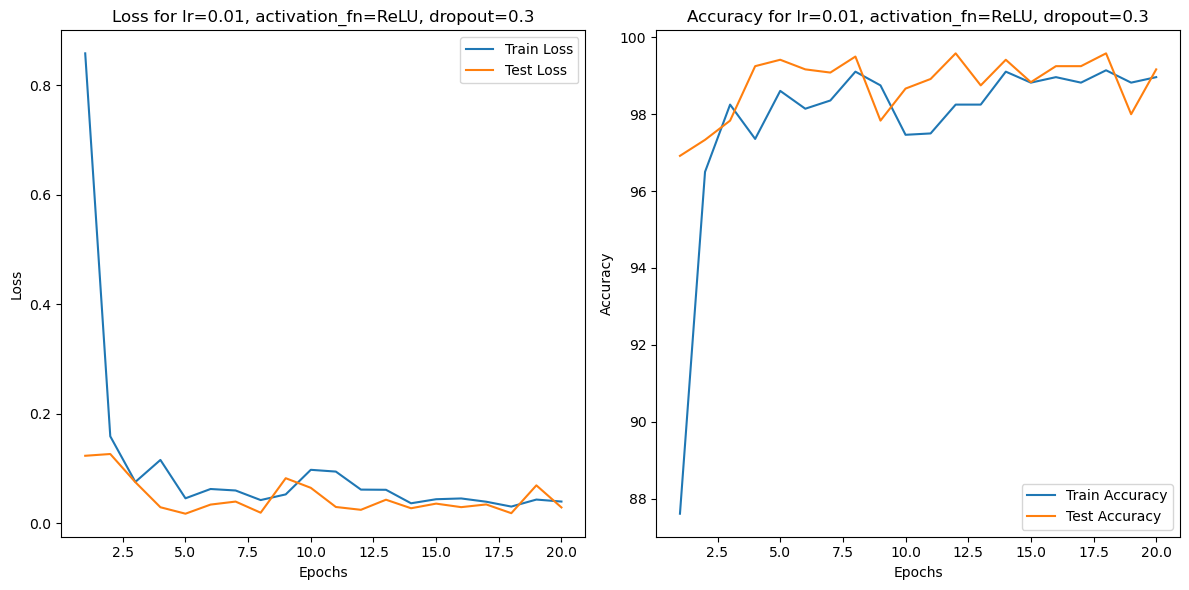


Training with lr=0.01, activation_fn=ReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.8068, Accuracy: 87.68%
Epoch 2/20, Loss: 0.1613, Accuracy: 96.57%
Epoch 3/20, Loss: 0.1206, Accuracy: 97.25%
Epoch 4/20, Loss: 0.0848, Accuracy: 97.54%
Epoch 5/20, Loss: 0.0559, Accuracy: 98.71%
Epoch 6/20, Loss: 0.0895, Accuracy: 97.68%
Epoch 7/20, Loss: 0.0720, Accuracy: 98.25%
Epoch 8/20, Loss: 0.0588, Accuracy: 98.75%
Epoch 9/20, Loss: 0.1509, Accuracy: 96.32%
Epoch 10/20, Loss: 0.0718, Accuracy: 98.32%
Epoch 11/20, Loss: 0.0680, Accuracy: 98.25%
Epoch 12/20, Loss: 0.1345, Accuracy: 97.64%
Epoch 13/20, Loss: 0.1731, Accuracy: 96.46%
Epoch 14/20, Loss: 0.0997, Accuracy: 97.32%
Epoch 15/20, Loss: 0.0336, Accuracy: 99.07%
Epoch 16/20, Loss: 0.0383, Accuracy: 98.93%
Epoch 17/20, Loss: 0.0380, Accuracy: 99.14%
Epoch 18/20, Loss: 0.1015, Accuracy: 97.14%
Epoch 19/20, Loss: 0.0549, Accuracy: 98.32%
Epoch 20/20, Loss: 0.0348, Accuracy: 99.11%

Test Accuracy: 99.25%


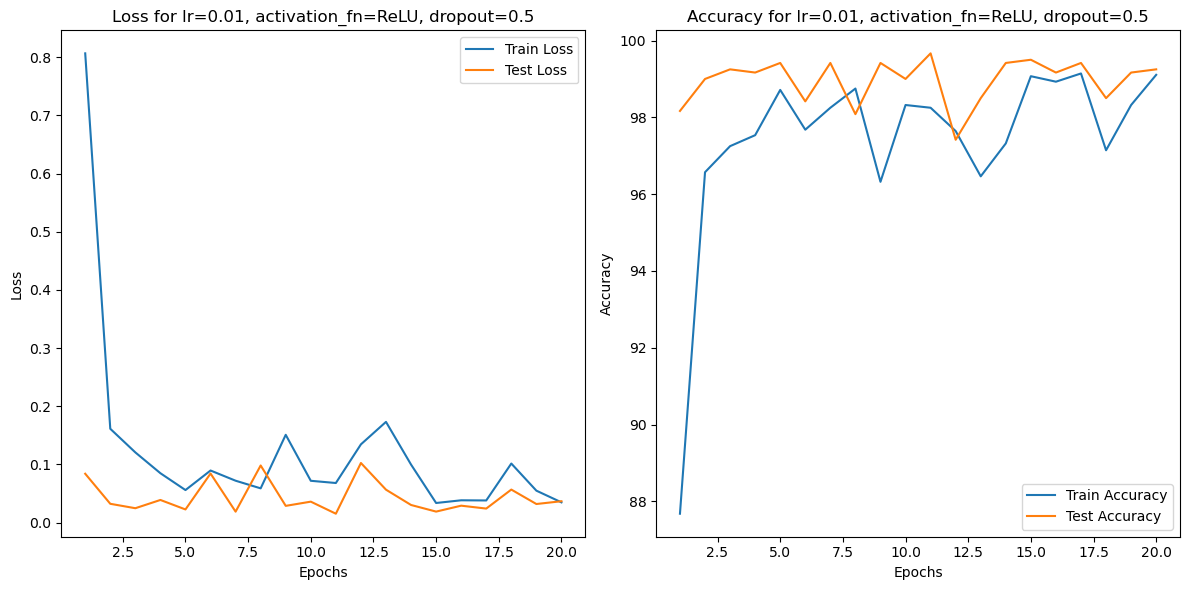


Training with lr=0.01, activation_fn=LeakyReLU, dropout_rate=0.2
Epoch 1/20, Loss: 1.2841, Accuracy: 88.46%
Epoch 2/20, Loss: 0.2621, Accuracy: 94.64%
Epoch 3/20, Loss: 0.2319, Accuracy: 96.29%
Epoch 4/20, Loss: 0.0568, Accuracy: 98.36%
Epoch 5/20, Loss: 0.0574, Accuracy: 98.57%
Epoch 6/20, Loss: 0.0783, Accuracy: 98.18%
Epoch 7/20, Loss: 0.0663, Accuracy: 98.36%
Epoch 8/20, Loss: 0.0421, Accuracy: 98.79%
Epoch 9/20, Loss: 0.0591, Accuracy: 98.18%
Epoch 10/20, Loss: 0.0756, Accuracy: 98.25%
Epoch 11/20, Loss: 0.0482, Accuracy: 98.79%
Epoch 12/20, Loss: 0.0722, Accuracy: 97.89%
Epoch 13/20, Loss: 0.0394, Accuracy: 98.93%
Epoch 14/20, Loss: 0.0442, Accuracy: 98.54%
Epoch 15/20, Loss: 0.0449, Accuracy: 98.71%
Epoch 16/20, Loss: 0.0872, Accuracy: 98.18%
Epoch 17/20, Loss: 0.0345, Accuracy: 99.21%
Epoch 18/20, Loss: 0.0417, Accuracy: 99.11%
Epoch 19/20, Loss: 0.0344, Accuracy: 99.07%
Epoch 20/20, Loss: 0.0410, Accuracy: 98.96%

Test Accuracy: 99.50%


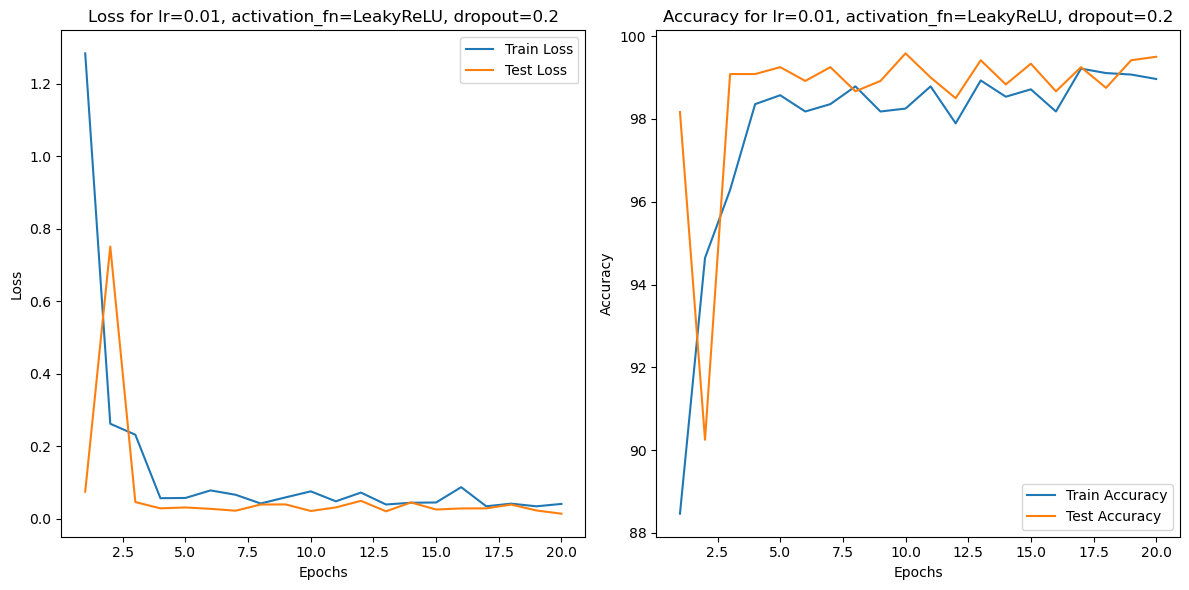


Training with lr=0.01, activation_fn=LeakyReLU, dropout_rate=0.3
Epoch 1/20, Loss: 1.6329, Accuracy: 85.89%
Epoch 2/20, Loss: 0.0836, Accuracy: 97.82%
Epoch 3/20, Loss: 0.1747, Accuracy: 96.07%
Epoch 4/20, Loss: 0.0705, Accuracy: 98.18%
Epoch 5/20, Loss: 0.1153, Accuracy: 97.32%
Epoch 6/20, Loss: 0.4653, Accuracy: 92.36%
Epoch 7/20, Loss: 0.0916, Accuracy: 97.71%
Epoch 8/20, Loss: 0.0579, Accuracy: 98.46%
Epoch 9/20, Loss: 0.0454, Accuracy: 98.61%
Epoch 10/20, Loss: 0.0437, Accuracy: 99.00%
Epoch 11/20, Loss: 0.0409, Accuracy: 98.93%
Epoch 12/20, Loss: 0.0501, Accuracy: 98.57%
Epoch 13/20, Loss: 0.0287, Accuracy: 99.21%
Epoch 14/20, Loss: 0.0422, Accuracy: 98.86%
Epoch 15/20, Loss: 0.0332, Accuracy: 99.11%
Epoch 16/20, Loss: 0.0517, Accuracy: 98.68%
Epoch 17/20, Loss: 0.0369, Accuracy: 99.00%
Epoch 18/20, Loss: 0.0388, Accuracy: 99.11%
Epoch 19/20, Loss: 0.0325, Accuracy: 99.18%
Epoch 20/20, Loss: 0.0365, Accuracy: 99.25%

Test Accuracy: 99.50%


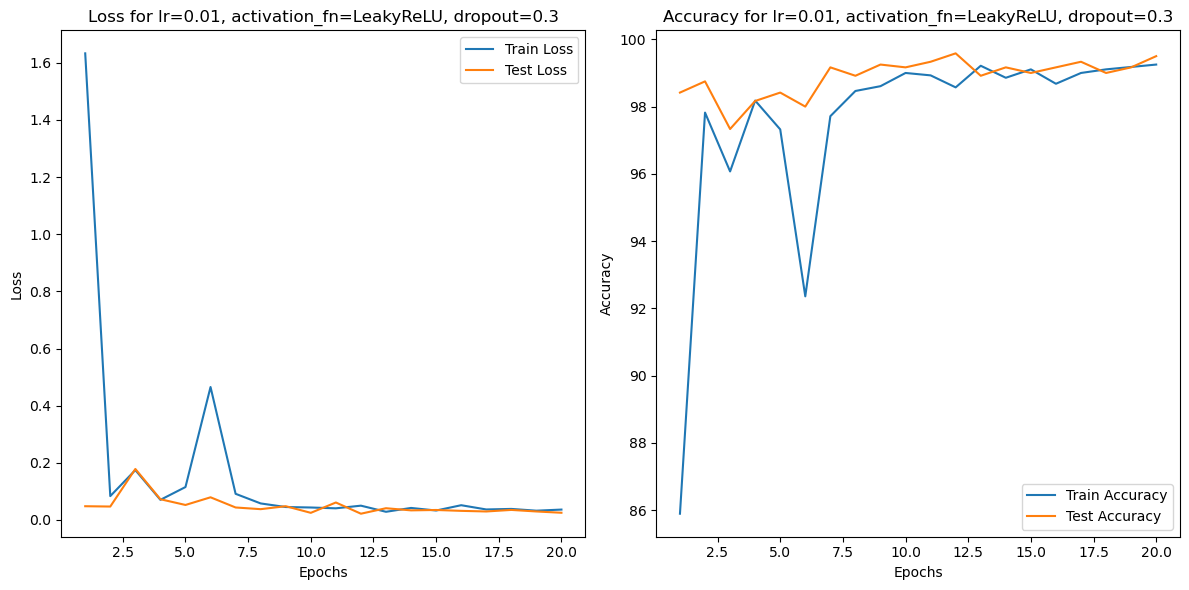


Training with lr=0.01, activation_fn=LeakyReLU, dropout_rate=0.5
Epoch 1/20, Loss: 0.5885, Accuracy: 90.57%
Epoch 2/20, Loss: 0.1833, Accuracy: 95.39%
Epoch 3/20, Loss: 0.1232, Accuracy: 97.07%
Epoch 4/20, Loss: 0.0853, Accuracy: 98.11%
Epoch 5/20, Loss: 0.0592, Accuracy: 98.46%
Epoch 6/20, Loss: 0.0532, Accuracy: 98.61%
Epoch 7/20, Loss: 0.0682, Accuracy: 98.46%
Epoch 8/20, Loss: 0.0509, Accuracy: 98.86%
Epoch 9/20, Loss: 0.0505, Accuracy: 98.43%
Epoch 10/20, Loss: 0.0506, Accuracy: 98.79%
Epoch 11/20, Loss: 0.0536, Accuracy: 98.54%
Epoch 12/20, Loss: 0.0721, Accuracy: 98.43%
Epoch 13/20, Loss: 0.1239, Accuracy: 97.32%
Epoch 14/20, Loss: 0.0632, Accuracy: 98.46%
Epoch 15/20, Loss: 615.9823, Accuracy: 81.96%
Epoch 16/20, Loss: 1173.0538, Accuracy: 90.32%
Epoch 17/20, Loss: 231.7027, Accuracy: 97.54%
Epoch 18/20, Loss: 37.8509, Accuracy: 98.93%
Epoch 19/20, Loss: 14.2949, Accuracy: 99.29%
Epoch 20/20, Loss: 14.1459, Accuracy: 99.04%

Test Accuracy: 99.75%


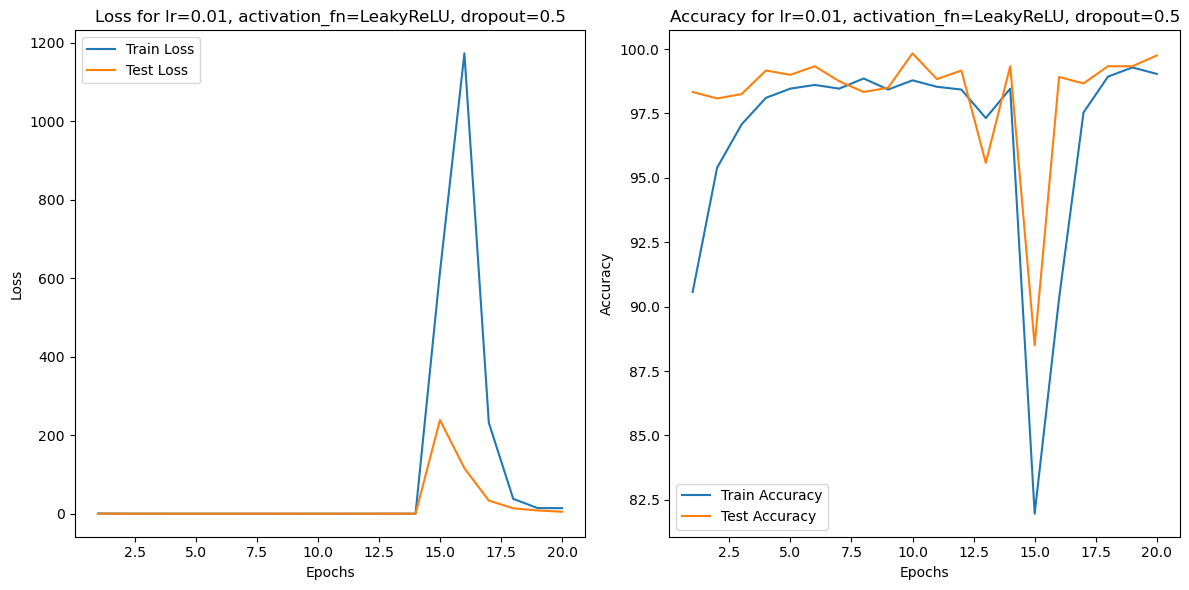


Training with lr=0.01, activation_fn=ELU, dropout_rate=0.2
Epoch 1/20, Loss: 8.3607, Accuracy: 83.86%
Epoch 2/20, Loss: 4.5999, Accuracy: 95.75%
Epoch 3/20, Loss: 25.7441, Accuracy: 95.64%
Epoch 4/20, Loss: 21.4298, Accuracy: 97.61%
Epoch 5/20, Loss: 16.1056, Accuracy: 98.29%
Epoch 6/20, Loss: 16.4663, Accuracy: 98.14%
Epoch 7/20, Loss: 156.0516, Accuracy: 97.25%
Epoch 8/20, Loss: 19.2140, Accuracy: 98.89%
Epoch 9/20, Loss: 6.6317, Accuracy: 99.61%
Epoch 10/20, Loss: 1.7072, Accuracy: 99.71%
Epoch 11/20, Loss: 2.2660, Accuracy: 99.75%
Epoch 12/20, Loss: 3.6547, Accuracy: 99.64%
Epoch 13/20, Loss: 5.8418, Accuracy: 99.50%
Epoch 14/20, Loss: 39.3420, Accuracy: 98.89%
Epoch 15/20, Loss: 2313.6936, Accuracy: 97.04%
Epoch 16/20, Loss: 247.6723, Accuracy: 99.07%
Epoch 17/20, Loss: 32.4416, Accuracy: 99.64%
Epoch 18/20, Loss: 27.7172, Accuracy: 99.71%
Epoch 19/20, Loss: 17.9841, Accuracy: 99.68%
Epoch 20/20, Loss: 13.6297, Accuracy: 99.75%

Test Accuracy: 99.42%


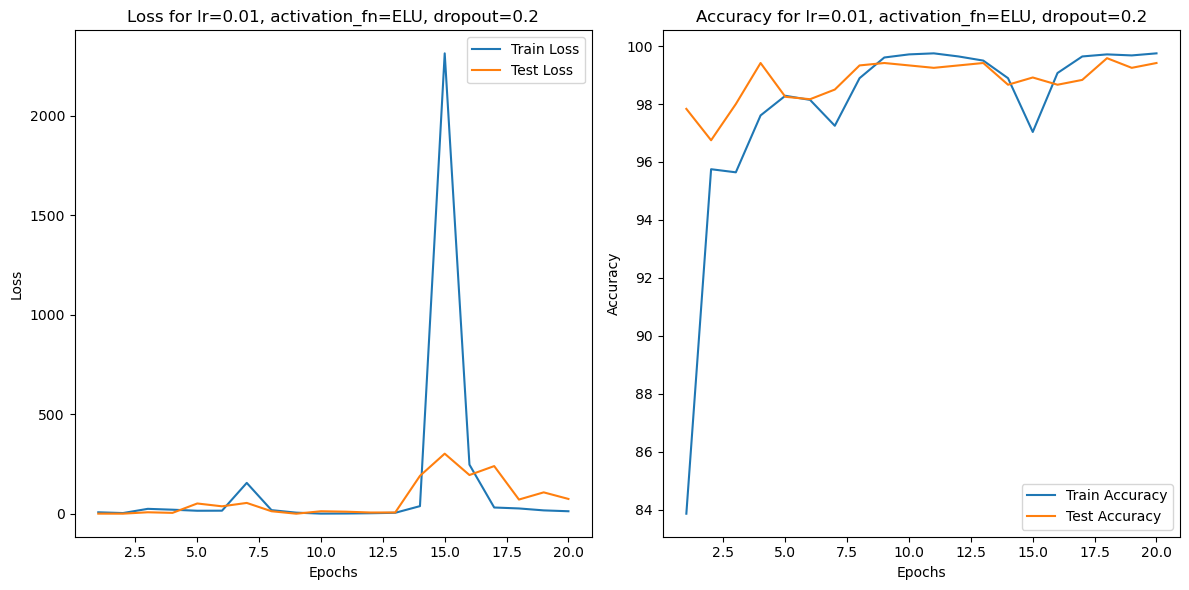


Training with lr=0.01, activation_fn=ELU, dropout_rate=0.3
Epoch 1/20, Loss: 21.3922, Accuracy: 88.61%
Epoch 2/20, Loss: 14.8836, Accuracy: 95.89%
Epoch 3/20, Loss: 5.9901, Accuracy: 97.68%
Epoch 4/20, Loss: 1.4078, Accuracy: 98.96%
Epoch 5/20, Loss: 3.2373, Accuracy: 98.50%
Epoch 6/20, Loss: 3.6946, Accuracy: 98.57%
Epoch 7/20, Loss: 5.1282, Accuracy: 98.36%
Epoch 8/20, Loss: 181.3800, Accuracy: 94.57%
Epoch 9/20, Loss: 63.8892, Accuracy: 98.64%
Epoch 10/20, Loss: 10.4469, Accuracy: 99.39%
Epoch 11/20, Loss: 7.4987, Accuracy: 99.18%
Epoch 12/20, Loss: 7.9706, Accuracy: 99.46%
Epoch 13/20, Loss: 4.2279, Accuracy: 99.50%
Epoch 14/20, Loss: 19.5963, Accuracy: 99.04%
Epoch 15/20, Loss: 21.7812, Accuracy: 99.36%
Epoch 16/20, Loss: 39.7527, Accuracy: 98.82%
Epoch 17/20, Loss: 38.5039, Accuracy: 99.04%
Epoch 18/20, Loss: 102.4486, Accuracy: 98.86%
Epoch 19/20, Loss: 41.4384, Accuracy: 99.25%
Epoch 20/20, Loss: 2.0879, Accuracy: 99.79%

Test Accuracy: 99.58%


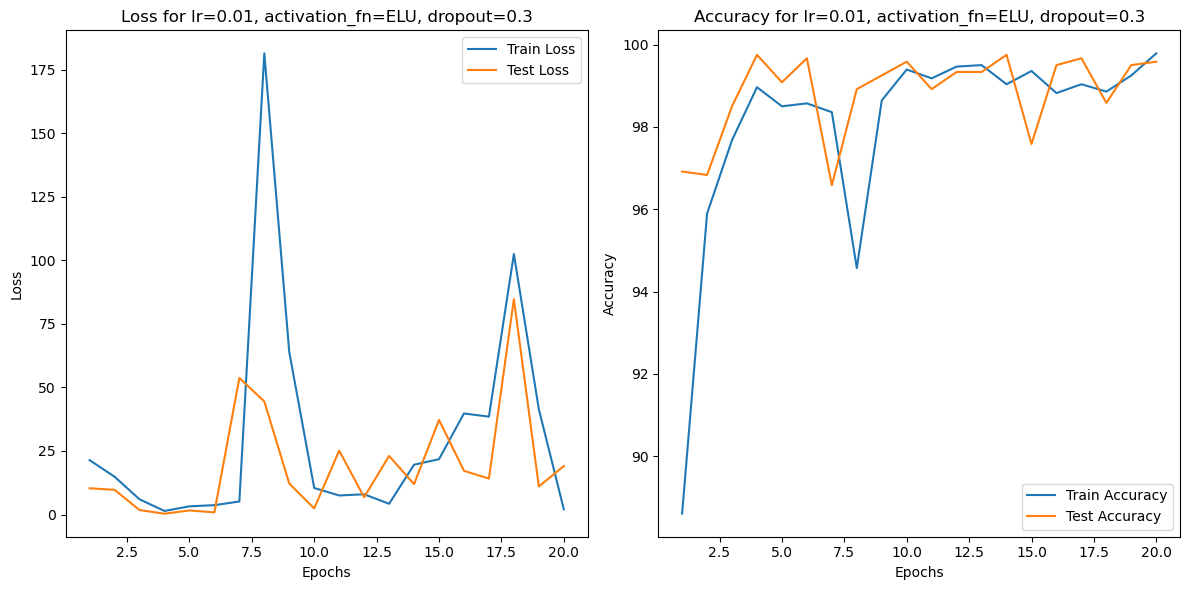


Training with lr=0.01, activation_fn=ELU, dropout_rate=0.5
Epoch 1/20, Loss: 23.7142, Accuracy: 87.71%
Epoch 2/20, Loss: 25.6244, Accuracy: 96.04%
Epoch 3/20, Loss: 8.5984, Accuracy: 98.11%
Epoch 4/20, Loss: 6.6833, Accuracy: 98.54%
Epoch 5/20, Loss: 9.0147, Accuracy: 98.32%
Epoch 6/20, Loss: 5.1433, Accuracy: 98.89%
Epoch 7/20, Loss: 160.1583, Accuracy: 95.43%
Epoch 8/20, Loss: 118.7756, Accuracy: 95.36%
Epoch 9/20, Loss: 46.1216, Accuracy: 98.39%
Epoch 10/20, Loss: 36.3116, Accuracy: 98.71%
Epoch 11/20, Loss: 16.1865, Accuracy: 99.21%
Epoch 12/20, Loss: 16.4057, Accuracy: 99.11%
Epoch 13/20, Loss: 21.7424, Accuracy: 99.21%
Epoch 14/20, Loss: 4.3808, Accuracy: 99.75%
Epoch 15/20, Loss: 14.6826, Accuracy: 99.32%
Epoch 16/20, Loss: 68.9661, Accuracy: 98.89%
Epoch 17/20, Loss: 162.8935, Accuracy: 97.93%
Epoch 18/20, Loss: 20.8046, Accuracy: 99.36%
Epoch 19/20, Loss: 14.9780, Accuracy: 99.36%
Epoch 20/20, Loss: 14.4008, Accuracy: 99.75%

Test Accuracy: 99.58%


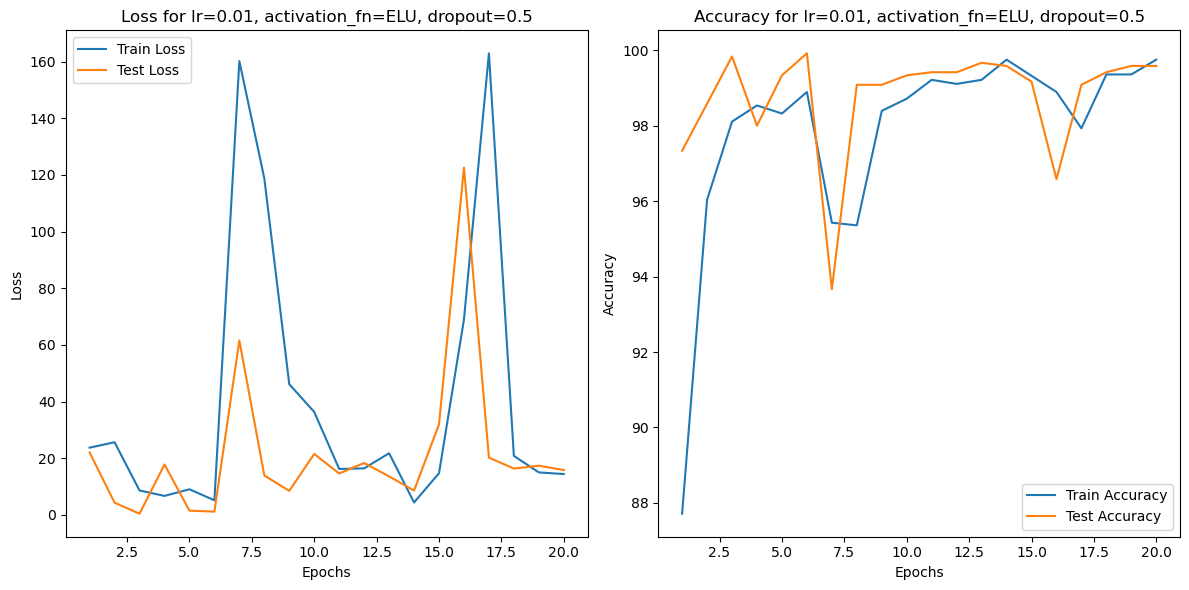

Best Hyperparameters: {'learning_rate': 0.001, 'activation_fn': 'LeakyReLU', 'dropout_rate': 0.2}
Classification Report for Test Set:
Classification Report:

              precision    recall  f1-score   support

   BreastMRI       1.00      1.00      1.00       300
     ChestCT       1.00      0.99      1.00       300
         CXR       1.00      1.00      1.00       300
        Hand       0.99      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



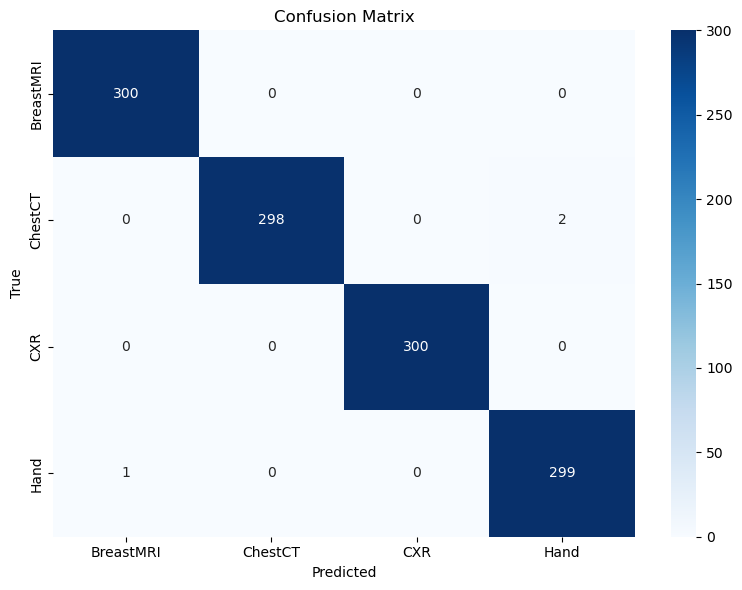

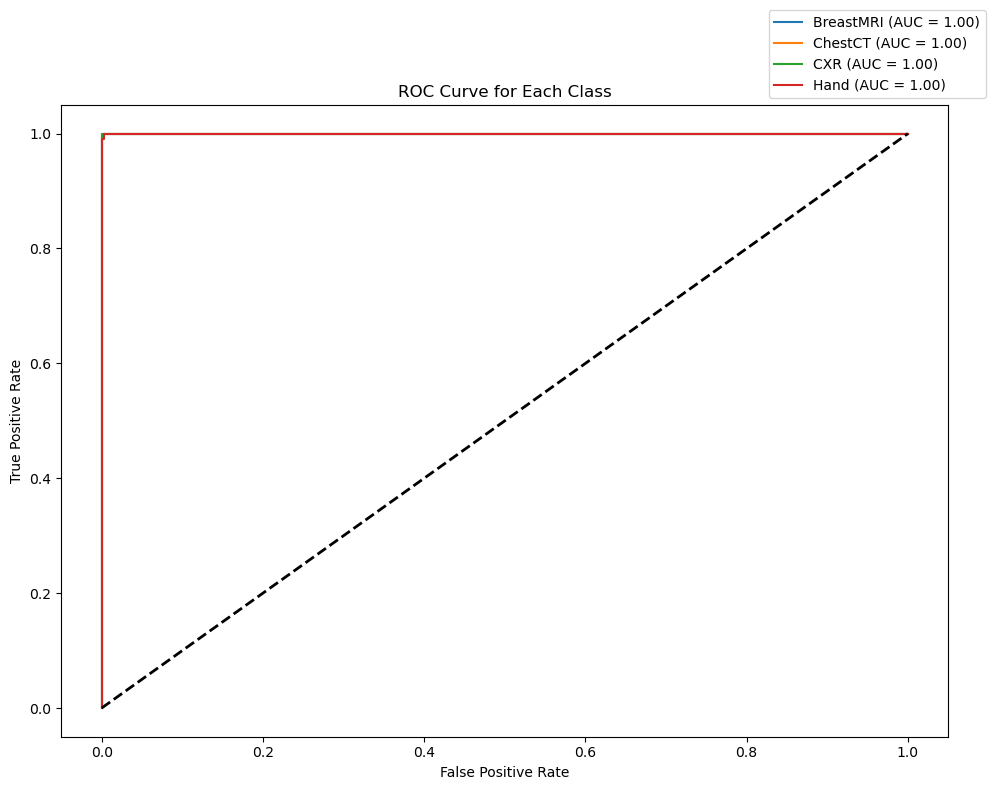

In [113]:
# Συνάρτηση για την εκτύπωση του classification report και της confusion matrix
def evaluate_model(model, X_data_tensor, y_data_tensor, class_names, device):
    model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    with torch.no_grad():
        # Στείλουμε τα δεδομένα στην ίδια συσκευή με το μοντέλο
        X_data_tensor = X_data_tensor.to(device)
        y_data_tensor = y_data_tensor.to(device)

        # Υπολογισμός εξόδου
        outputs = model(X_data_tensor)
        _, predicted = torch.max(outputs, 1)

    # Μεταφορά των προβλέψεων και των αληθινών ετικετών στη CPU
    y_pred = predicted.cpu().numpy()
    y_true = y_data_tensor.cpu().numpy()

    # Εκτύπωση του Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Υπολογισμός της Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Εμφάνιση της Confusion Matrix ως heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return y_true, y_pred


# Συνάρτηση για τη δημιουργία της ROC Curve
def plot_roc_curve(model, X_test_tensor, y_test_encoded, class_names, device):
    # Binarize the true labels for ROC
    y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(class_names)))

    # Στείλουμε τα δεδομένα στην ίδια συσκευή με το μοντέλο
    X_test_tensor = X_test_tensor.to(device)
    y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = torch.softmax(outputs, dim=1)

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Υπολογισμός ROC και AUC για κάθε κατηγορία
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i].cpu().numpy())
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Σχεδίαση ROC curve για κάθε κατηγορία
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Διαχωριστική γραμμή για τυχαία απόδοση
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Εκπαίδευση με διαφορετικές υπερπαραμέτρους
learning_rates = [0.001, 0.0001, 0.01]
activation_functions = ['ReLU', 'LeakyReLU', 'ELU']
dropout_rates = [0.2, 0.3, 0.5]

best_accuracy = 0.0
best_model_params = {}

# Loop για πειραματισμό με υπερπαραμέτρους
for lr in learning_rates:
    for activation_fn in activation_functions:
        for dropout_rate in dropout_rates:
            print(f"\nTraining with lr={lr}, activation_fn={activation_fn}, dropout_rate={dropout_rate}")
            
            # Δημιουργία μοντέλου με τις τρέχουσες υπερπαραμέτρους
            model = CNN(num_classes=len(np.unique(y_train)), dropout_rate=dropout_rate, activation_fn=activation_fn)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # L2 regularization
            
            # Εκπαίδευση του μοντέλου (χρησιμοποιώντας την προσαρμοσμένη train_model συνάρτηση)
            train_losses, train_accuracies, test_losses, test_accuracies = train_model(
                model, criterion, optimizer, train_loader, test_loader
            )
            
            # Εξαγωγή του καλύτερου μοντέλου
            final_test_accuracy = test_accuracies[-1]
            if final_test_accuracy > best_accuracy:
                best_accuracy = final_test_accuracy
                best_model_params = {
                    'learning_rate': lr,
                    'activation_fn': activation_fn,
                    'dropout_rate': dropout_rate
                }
                torch.save(model.state_dict(), 'best_model.pth')

            # Οπτικοποίηση των αποτελεσμάτων (Απώλειες και Ακρίβεια)
            plt.figure(figsize=(12, 6))

            # Καμπύλες Απώλειας
            plt.subplot(1, 2, 1)
            plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
            plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
            plt.title(f'Loss for lr={lr}, activation_fn={activation_fn}, dropout={dropout_rate}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Καμπύλες Ακρίβειας
            plt.subplot(1, 2, 2)
            plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
            plt.title(f'Accuracy for lr={lr}, activation_fn={activation_fn}, dropout={dropout_rate}')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

# Φόρτωση του καλύτερου μοντέλου
best_model = CNN(num_classes=len(np.unique(y_train)), activation_fn=best_model_params['activation_fn'], dropout_rate=best_model_params['dropout_rate'])
best_model.load_state_dict(torch.load('best_model.pth'))
criterion = torch.nn.CrossEntropyLoss()
best_model.eval()

# Εκτίμηση του μοντέλου (Classification Report, Confusion Matrix, ROC Curve)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Εκτύπωση των καλύτερων υπερπαραμέτρων και αξιολόγηση
print(f"Best Hyperparameters: {best_model_params}")

# Αξιολόγηση στο Test Set
print("Classification Report for Test Set:")
y_true, y_pred = evaluate_model(best_model, X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long), class_names, device)

# Εκτύπωση ROC Curve
plot_roc_curve(best_model, X_test_tensor, y_test_encoded, class_names, device)